# ETF Portfolio Optimization & Dynamic Asset Allocation

**Last updated:** 2025-07-18

==============================================================================

       PORTFOLIO OPTIMIZATION & DYNAMIC ASSET ALLOCATION

==============================================================================

OVERVIEW:

This script performs a comprehensive portfolio analysis using various optimization
techniques. It begins with classic Mean-Variance Optimization and then explores
more advanced methods to create robust and dynamic asset allocation strategies.

The script is divided into the following main sections:

  1.  SETUP & CONFIGURATION:
      -   Loads necessary libraries and defines global settings.

  2.  DATA LOADING & PREPARATION:
      -   Fetches a list of Vanguard ETFs and their metadata via web scraping.
      -   Downloads historical price data for these ETFs from Yahoo Finance.
      -   Processes the data to calculate monthly returns over a specified window.

  3.  STATIC PORTFOLIO ANALYSIS (MEAN-VARIANCE OPTIMIZATION):
      -   Calculates expected returns and covariance, applying "shrinkage"
          techniques (Ledoit-Wolf) for more stable estimates.
      -   Computes the "Efficient Frontier" to find optimal portfolios.
      -   Applies L1 regularization to remove small weights.
      -   Constructs several static portfolios and compares them to a benchmark (VOO).

  4.  ADVANCED STATIC MODELS & ROBUSTNESS CHECKS:
      -   Implements Resampled Efficient Frontier, Rolling Window analysis,
          Black-Litterman, Risk Parity, Hierarchical Risk Parity (HRP), and
          DCC-GARCH models to create more robust portfolios.

  5.  REGIME-SWITCHING MODEL:
      -   Loads external economic data (VIX, Treasury yields) to help
          identify distinct market "regimes" (e.g., low-volatility growth,
          high-volatility decline).
      -   Fits a Markov Regime-Switching model to the market data.

  6.  REGIME-AWARE DYNAMIC STRATEGY:
      -   Calculates an optimal portfolio for each identified market regime.
      -   Backtests a dynamic strategy that adjusts its portfolio allocation
          based on the real-time probability of being in each regime.

  7.  FINAL PERFORMANCE COMPARISON:
      -   Plots the cumulative returns of all tested strategies.
      -   Calculates and displays a table of key performance metrics (Return,
          Volatility, Sharpe Ratio, Max Drawdown) for a comprehensive comparison.
      -   Runs a Monte Carlo simulation to forecast future performance.

==============================================================================
==============================================================================

### 1. Setup & Configuration

This cell imports required Python libraries, sets global display options,
and defines helper functions used throughout the analysis.

As a first step, load all package we are going to use.  There is a lot we will do, so we need to load a lot of packages.

In [15]:
# ==============================================================================
# --- Standard Library Imports ---
import os
import re
import time
import warnings

# --- Third-Party Library Imports ---
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import cvxopt as opt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
from arch.univariate import ConstantMean, GARCH
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from pandas_datareader.data import DataReader
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import warnings
from arch.univariate.base import DataScaleWarning   

# --- Global Settings & Constants ---
# Set the working directory.
# NOTE: You may need to change this path to your project's root directory.
DIRECTORY = "."
os.chdir(DIRECTORY)

# Analysis Period
ANALYSIS_YEARS = 15

# Optimization & Simulation Parameters
FRONTIER_POINTS = 50  # Number of points to calculate on the efficient frontier.
MC_SIM_SCENARIOS = 10000  # Number of scenarios for Monte Carlo simulation.
MC_SIM_HORIZON_MONTHS = 120  # 10-year horizon for simulation.
RESAMPLE_ITERATIONS = 100  # Number of bootstrap iterations for resampled frontier.
ROLLING_WINDOW_MONTHS = 60  # 5-year rolling window for dynamic weight analysis.

# Regime Modeling Parameters
MIN_OBS_PER_REGIME = 10  # Minimum data points required to consider a regime valid.
MAX_REGIMES_TO_TEST = 4  # Test models with 2 up to this number of regimes.

# --- Initial Setup ---
# Configure pandas for better display
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Configure the CVXOPT solver to not display progress messages
opt.solvers.options["show_progress"] = False

# Suppress convergence warnings from statsmodels fitting procedures
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress warning from arch model fitting 
warnings.filterwarnings("ignore", category=DataScaleWarning)


# ==============================================================================

### 2. Data Loading & Preparation

What we will do in this section:
* **ETF universe:** Scrape the latest list of Vanguard ETFs.
* **Historical prices:** Retrieve adjusted close prices from Yahoo Finance via `yfinance`.
* **Return series:** Compute monthly log‑returns and align the date index.

First, we will need to find a systematic way to identify ETFs we can invest into.  Luckily, Vanguard is one of the leading ETF brokers and provides a great list of available ETFs [here](https://advisors.vanguard.com/investments/etfs).  We can just download the ETF list as csv-file, or we can scrape the table from the website directly.  I go with the latter solution so I always have the latest ETF list ready for the program.

The approach is quite straightforward: we use a webdriver to identify the table on the website, collect the relevant cells via their tags (in our case, ticker, ETF name, and expense ration), and click to the next page to do the same again.  You only need to make sure to add the path to the webdriver, in my case chromedriver. 

In [8]:
# We use Selenium to scrape the Vanguard advisor site for an up-to-date list of
# tickers, names, and expense ratios.
def extract_etf_data_from_page(driver_instance):
    """
    Extracts ETF data (Symbol, Name, Expense Ratio) from the currently
    viewed table on the Vanguard website.

    Args:
        driver_instance: The active Selenium WebDriver instance.

    Returns:
        A list of dictionaries, where each dictionary represents an ETF.
    """
    data = []
    try:
        table_body = driver_instance.find_element(By.CSS_SELECTOR, "table tbody")
        rows = table_body.find_elements(By.TAG_NAME, "tr")
        for row in rows:
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                symbol = cells[0].text.strip()
                # Fund name is in a nested div; clean up extraneous text like "NEW FUND"
                raw_name = row.find_elements(By.TAG_NAME, "div")[1].text.strip()
                fund_name = re.sub(
                    r"\s*(NEW FUND)?\s*$", "", raw_name.replace("\n", " ")
                ).strip()
                # Expense ratio is in the 8th column; clean and convert to float
                expense_text = cells[7].text.strip().replace("%", "").strip()
                expense_ratio = float(expense_text) / 100 if expense_text else None
                data.append(
                    {
                        "Symbol": symbol,
                        "Fund name": fund_name,
                        "Expense ratio": expense_ratio,
                    }
                )
            except (IndexError, ValueError):
                # Skip row if any element is missing or fails to parse
                continue
    except Exception as e:
        print(f"Error extracting table data: {e}")
    return data


try:
    print("Scraping ETF data from Vanguard website...")
    # Setup Selenium Chrome driver in headless mode (no visible browser window)
    chrome_options = Options()
    chrome_options.add_argument("--headless=new")
    chrome_options.add_argument("--disable-gpu")

    # IMPORTANT: Update this path to your local chromedriver executable.
    # For better portability, consider using webdriver-manager:
    # from webdriver_manager.chrome import ChromeDriverManager
    # service = Service(ChromeDriverManager().install())
    chrome_service = Service(executable_path="/Users/dominikjurek/Library/CloudStorage/Dropbox/Personal/Investment/chromedriver")
    
    driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

    # Step 1: Load the Vanguard ETF page and wait for it to render
    driver.get("https://advisors.vanguard.com/investments/etfs")
    time.sleep(6)  # Allow time for JavaScript to load the table

    # Step 2: Extract data from the first page
    all_etf_data = extract_etf_data_from_page(driver)

    # Step 3: Click the "Next page" button to load the remaining ETFs
    try:
        next_button = driver.find_element(
            By.XPATH, '//button[@aria-label[contains(., "Forward one page")]]'
        )
        next_button.click()
        time.sleep(5)  # Wait for the second page to load
        all_etf_data += extract_etf_data_from_page(driver)
    except Exception as e:
        print(f"Could not navigate to the second page (or it doesn't exist): {e}")

    # Step 4: Process the scraped data
    df_etf_metadata = pd.DataFrame(all_etf_data)
    etf_name_map = dict(zip(df_etf_metadata["Symbol"], df_etf_metadata["Fund name"]))
    etf_expense_map = dict(
        zip(df_etf_metadata["Symbol"], df_etf_metadata["Expense ratio"])
    )
    etf_symbols = list(etf_name_map.keys())
    print(f"Successfully extracted metadata for {len(etf_symbols)} ETFs.")
    print("Sample of extracted ETF data:")
    print(df_etf_metadata.head())
except Exception as e:
    # If scraping fails, fall back to a predefined list of core ETFs
    print(f"Could not complete web scraping. Reason: {e}")
    print("Falling back to a predefined list of core ETFs.")
    etf_symbols = [
        "VOO", "VTI", "VEA", "VWO", "BND", "BNDX", "VGIT", "VGLT", "VTIP", "MUB",
    ]
    etf_name_map = {s: s for s in etf_symbols}
    etf_expense_map = {s: 0.0003 for s in etf_symbols}  # Use a reasonable default
finally:
    if "driver" in locals() and driver:
        driver.quit()


Scraping ETF data from Vanguard website...
Successfully extracted metadata for 97 ETFs.
Sample of extracted ETF data:
  Symbol                       Fund name  Expense ratio
0   VBIL     0-3 Month Treasury Bill ETF          0.001
1   VTEC  California Tax-Exempt Bond ETF          0.001
2    VOX      Communication Services ETF          0.001
3    VCR      Consumer Discretionary ETF          0.001
4    VDC            Consumer Staples ETF          0.001


I want to ensure that my investment strategy is supported by broadly diversified ETFs, so I manually remove all industry-specific ETFs.  This is not really necessary to run the code or identify optimal portfolios, especially since the industry indices are themselves relatively well diversified across dozen or even hundreds of stocks.

In [9]:
# To create a diversified portfolio of broad asset classes, we remove
# specialized, sector-specific ETFs and redundant funds.
industry_keywords = [
    "Energy", "Health Care", "Consumer", "Materials", "Financials",
    "Utilities", "Real Estate", "Industrials", "Communication", "Information Technology",
]
# List of specific ETFs to remove (often sector-focused or overlapping)
remove_symbols = [
    "VGT", "VHT", "VPU", "VDC", "VAW", "VIS", "VFH", "VNQ", "VOX", "VDE", "VCR",
]


def is_industry_or_redundant(symbol, name_map):
    """Checks if an ETF is sector-specific or on the removal list."""
    name = name_map.get(symbol, "")
    is_industry = any(keyword in name for keyword in industry_keywords)
    is_redundant = symbol in remove_symbols
    return is_industry or is_redundant


etf_symbols = [s for s in etf_symbols if not is_industry_or_redundant(s, etf_name_map)]
etf_symbols = list(dict.fromkeys(etf_symbols))  # Ensure unique symbols
print(f"\nFiltered down to {len(etf_symbols)} ETFs for analysis.")



Filtered down to 85 ETFs for analysis.


Now it is time to download the price history for each of the ETFs from Yahoo Finance. 

In [10]:

def get_total_return_series(ticker):
    """
    Fetches maximum available historical prices for a ticker from Yahoo Finance,
    adjusted for dividends and splits to represent total return.

    Args:
        ticker (str): The stock or ETF symbol.

    Returns:
        pd.DataFrame: A DataFrame of historical adjusted closing prices.
                      Returns an empty DataFrame on failure.
    """
    print(f"Downloading data for {ticker}...")
    try:
        stock = yf.Ticker(ticker)
        # 'back_adjust=True' provides a total return series by adjusting historical
        # prices for both dividends and stock splits. 'auto_adjust=False' is required.
        df = stock.history(period="max", auto_adjust=False, back_adjust=True)[
            ["Close"]
        ].rename(columns={"Close": ticker})
        return df
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")
        return pd.DataFrame()


# Combine all price series into one DataFrame
all_prices_list = [get_total_return_series(ticker) for ticker in etf_symbols]
all_prices = pd.concat([df for df in all_prices_list if not df.empty], axis=1)

# Standardize the index to datetime objects without timezone information
all_prices.index = pd.to_datetime(all_prices.index).tz_localize(None)

# Resample daily prices to month-end, then calculate monthly percentage returns
returns_monthly = all_prices.resample("ME").last().pct_change()

# Limit data to the last N years for a more relevant analysis window
cutoff_date = returns_monthly.index.max() - pd.DateOffset(years=ANALYSIS_YEARS)
returns_monthly = returns_monthly[returns_monthly.index >= cutoff_date]

We will be using monthly observations for the most part, but we also need to remove NA values from the return table.  This is tricky, since the length of the ETF price history differs quite substantially, with some ET like the Total Treasury ETF (VTG) having no observations at all as it was created just recently.  Dropping all rows with NA values thus is not a solution.  Instead, we can require that ETFs have a minimum number of observations, in this case 10 years of data.  Since the ETF list on the website only contains currently available ETFs, we will drop all ETFs that have not at least 10 years of recent history.  We lose around around half of our ETFs through this, which is one of the main critiques of portfolio optimization: you need enough price history and basically have to exclude assets for which we cannot estimate covariances and expected returns.

In [11]:
# Data Cleaning:
# 1. Drop ETFs that do not have at least 10 years of non-NA observations
MIN_OBSERVATIONS = 10 * 12
returns_monthly = returns_monthly.dropna(axis=1, thresh=MIN_OBSERVATIONS)

# 2. Drop any month (row) that still has missing values
returns_monthly = returns_monthly.dropna(axis=0)

# Update final list of ETFs and related data based on the cleaned DataFrame
etf_symbols = returns_monthly.columns.tolist()

# The S&P 500 ETF (VOO) is our primary benchmark; it's required for the analysis.
if "VOO" not in etf_symbols:
    raise ValueError(
        "VOO data is missing or was dropped. It is required for benchmark comparison."
    )

# Create a NumPy array of expense ratios in the same order as our final ETF symbols
expense_vector = np.array([etf_expense_map.get(sym, 0.0) for sym in etf_symbols])

print(
    f"\nFinal analysis will use {len(etf_symbols)} ETFs over {len(returns_monthly)} months."
)
print(
    f"Analysis period: {returns_monthly.index.min().date()} to {returns_monthly.index.max().date()}"
)


Final analysis will use 55 ETFs over 145 months.
Analysis period: 2013-07-31 to 2025-07-31


Now we can explore the statistical properties of the ETFs we have.  With enough data, the central limit theorem tells us that we only need the first two moment to describe the distribution of random variables like returns, so let's have a look at means and variance.  

/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/1079853296.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (volatility[i], mean_returns[i]),


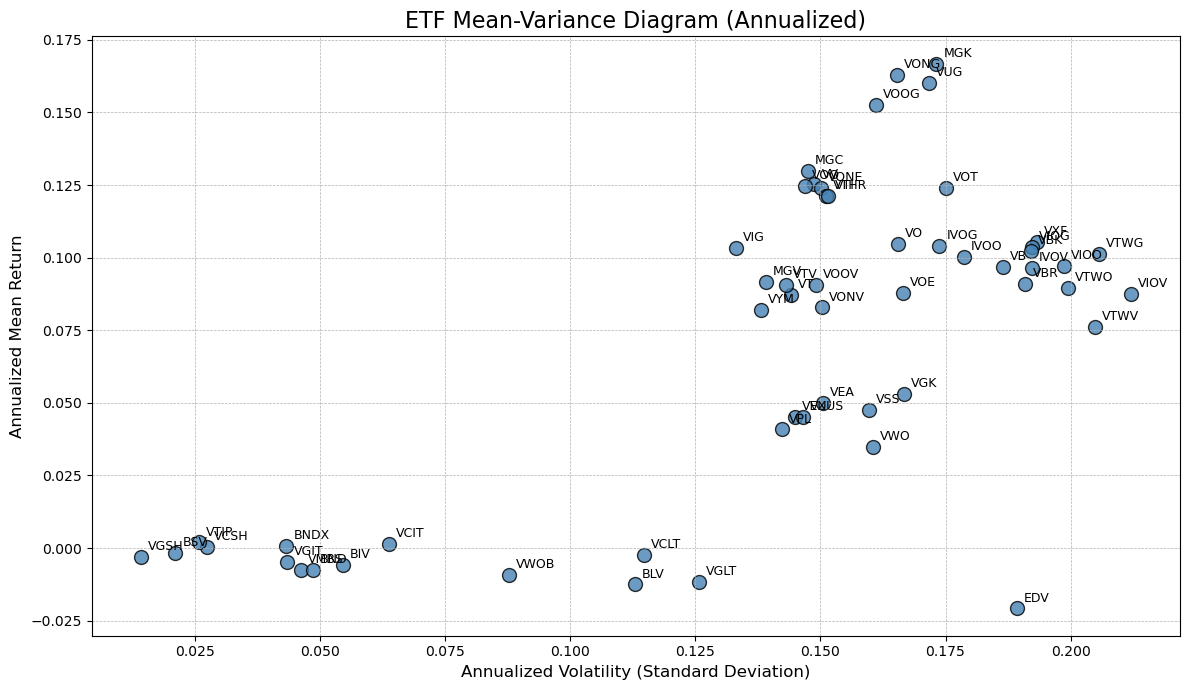

In [12]:
# Calculate annualized mean return and standard deviation
mean_returns = returns_monthly.mean() * 12  # 12 months in a year
volatility = returns_monthly.std() * np.sqrt(12)

# Create the scatter plot
plt.figure(figsize=(12, 7))
plt.scatter(volatility, mean_returns, color='steelblue', edgecolors='black', s=100, alpha=0.8)

# Annotate each ETF
for i, symbol in enumerate(etf_symbols):
    plt.annotate(symbol,
                 (volatility[i], mean_returns[i]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha='left', fontsize=9)

# Formatting the plot
plt.title("ETF Mean-Variance Diagram (Annualized)", fontsize=16)
plt.xlabel("Annualized Volatility (Standard Deviation)", fontsize=12)
plt.ylabel("Annualized Mean Return", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

As expected, there is quite a big variation.  Some ETFs have very low historic returns, like VCIT, the intermediate corporate bonds ETFs, but in exchange also low volatility.  That means, these ETFs are expected to have a small put relatively consistent return over time.  On the other hand, ETFs like MGK, Mega Cap Growth, have experienced very high return over the past 10 year (more than 17% p.a. on average!), but they were also enormously volatile.  

There is also the covariance between assets to consider.  

Let's first build some intuition how the covariance matrix of the ETFs actually looks like.

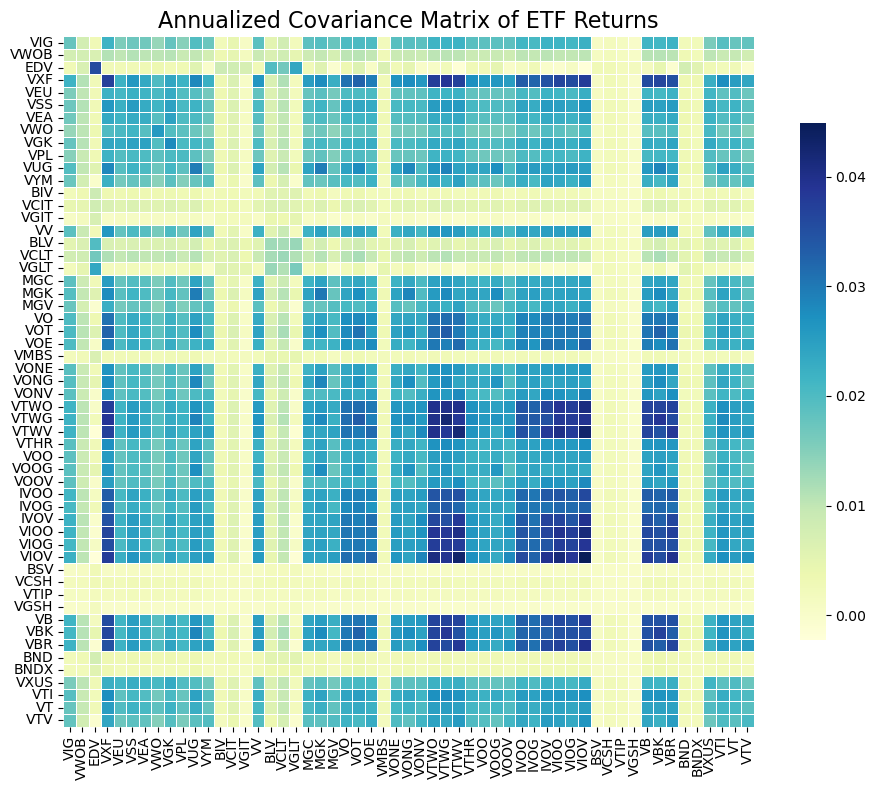

In [18]:
# Compute covariance matrix (annualized)
covariance_matrix = returns_monthly.cov() * 12

plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix,
            annot=False, fmt=".3f",
            cmap="YlGnBu",
            xticklabels=etf_symbols,
            yticklabels=etf_symbols,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.75})

plt.title("Annualized Covariance Matrix of ETF Returns", fontsize=16)
plt.tight_layout()
plt.show()

The covariance is quite widespread, just like the variance of in the diagonal.  Looking at the matrix, we actually can understand why portfolio optimization (and asset pricing in general) is focused on the covariance of assets.  There are only 55 elements in the diagonal (the variance of assets), but 55*54 elements everywhere else representing the covariance across assets.  So, it is much more important how asset co-vary with other assets rather than how volatile it is by itself. 

Let's also look at the correlation matrix:

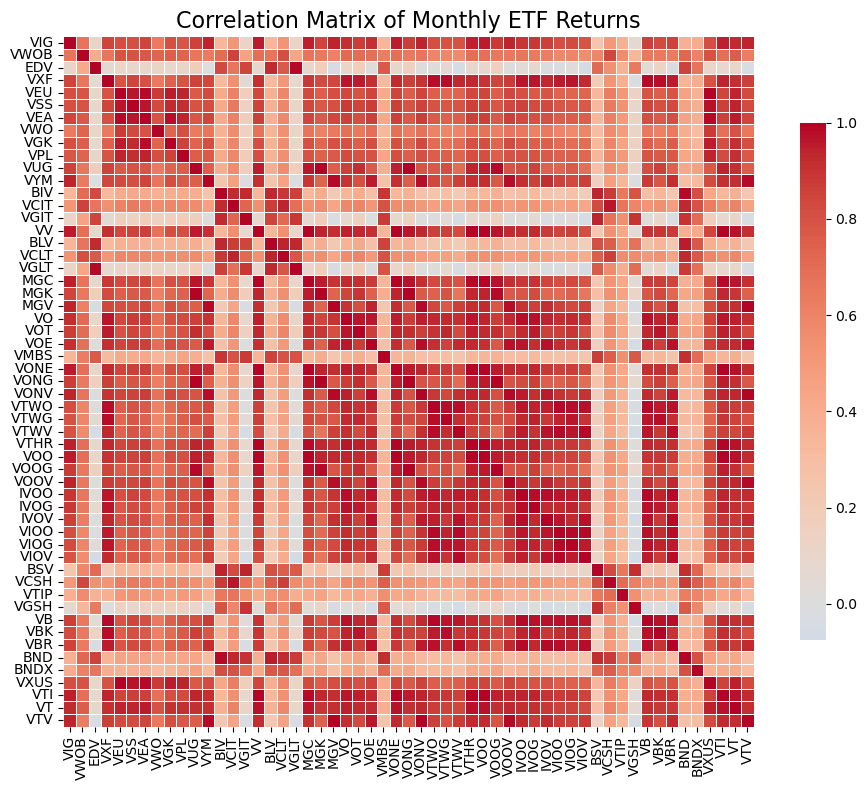

In [17]:
# Compute correlation matrix
correlation_matrix = returns_monthly.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=False, fmt=".2f",
            cmap="coolwarm", center=0,
            xticklabels=etf_symbols,
            yticklabels=etf_symbols,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.75})

plt.title("Correlation Matrix of Monthly ETF Returns", fontsize=16)
plt.tight_layout()
plt.show()

We already know assets have varying degrees of correlation from the covariance matrix, but the correlation matrix tells us one additional fact: no assets are perfectly correlated with each other (they would have a deep red color like the diagonal with correlation coefficient 1).  

This means that combinations of assets will have a lower variance than the weighted average of the variances.  To see why, consider the standard deviation of ETF 1 and ETF 2 and the linear combination of the two, with both asset not perfectly correlated

The portfolio variance of two assets is given by:

$$
\sigma_p^2 = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \rho_{12} \sigma_1 \sigma_2
$$

Since the correlation $\rho_{12} < 1$, the portfolio variance is **smaller** than the weighted average of the two ETF variances: 

$$
\sigma_p^2 < w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2
$$

For the expected returns, this is not true.  The expected return is a weighted average of the ETF expected returns.

$$
\mathbb{E}[R_p] = w_1 \mu_1 + w_2 \mu_2
$$

This is the idea behind **diversification**: by combining assets that are not perfectly correlated, the portfolio’s overall variance (risk) becomes lower than the average of the individual asset variances.  In other words, diversification helps smooth out the ups and downs, because not all assets move together.

Now we understand why diversification is great and we can try to find optimal portfolios that reduce the variance for a given expected return target, or maximize the expected return for a volatility/risk level we are willing to accept.

### 3. Static Portfolio Analysis — Mean‑Variance Optimization

In this section, we will define the efficient frontier based on the ETFs historic returns and covariance.

First, let's solve, the classic Markowitz (1952) problem:

$$
\min_{\mathbf{w}} \; \tfrac{1}{2} \mathbf{w}^\top \Sigma \mathbf{w}
\quad \text{subject to} \quad
\mathbf{w}^\top \mathbf{1} = 1, \quad
\mathbf{w}^\top \mu = \mu^*.
$$

That is, we find weights for the ETFs that minimize the variance of the portfolio that has the expected return $\mu^*$.  The only other constraint is that the weights sum up to one.  That's all.  We can build a efficient frontier with this approach by defining a sequence of target expected returns $\mu^*$ for the portfolios, between the smallest and largest returns of the ETFs, and solve for the minimum variance for each target $\mu^*$.  Since we are only dealing with first and second moments, so nothing of higher order than to the power of two, the minimization problem is convex and we can find unique portfolio weights that minimize the variance.

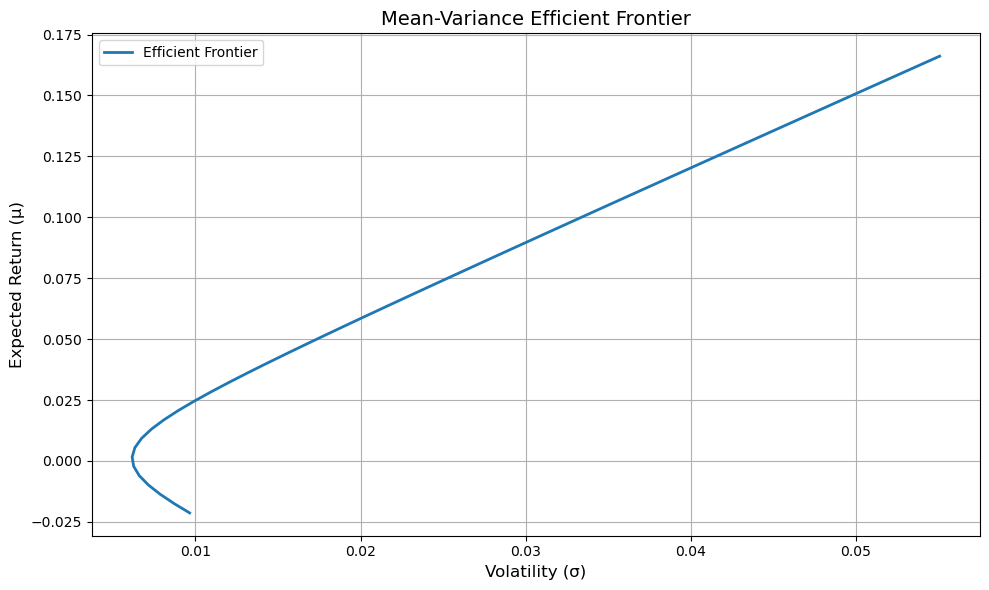

In [23]:
# These are the two key inputs for Markowitz portfolio optimization.
# 1. Expected Returns (mu): The anticipated annualized return for each asset.
# 2. Covariance Matrix (Sigma): A measure of how asset returns move together.

# Calculate historical annualized mean returns, net of expense ratios
annual_mu_sample = (returns_monthly.mean().values * 12) - expense_vector

# The sample covariance matrix is calculated from historical returns and annualized
sample_cov = returns_monthly.cov().values
annual_cov_sample = sample_cov * 12


def efficient_frontier_markowitz(expected_returns, covariance_matrix, n_points=50):
    """
    Computes the mean-variance efficient frontier using classic Markowitz optimization.

    Args:
        expected_returns (np.array): Vector of expected returns (annualized).
        covariance_matrix (np.array): Covariance matrix of returns (annualized).
        n_points (int): Number of portfolios to calculate along the frontier.

    Returns:
        dict: Contains lists of 'mu', 'sigma', and 'weights' for each portfolio.
    """
    n_assets = len(expected_returns)
    frontier = {"mu": [], "sigma": [], "weights": []}

    # Define QP parameters that don't change in the loop
    P = opt.matrix(covariance_matrix)
    q = opt.matrix(np.zeros(n_assets))
    
    # Equality constraint matrix A: one row for expected return, one for weights summing to 1
    A = opt.matrix(np.vstack([expected_returns, np.ones(n_assets)]))
    
    # Range of target returns
    target_mus = np.linspace(expected_returns.min(), expected_returns.max(), n_points)

    for mu_target in target_mus:
        b = opt.matrix([mu_target, 1.0])  # RHS of constraints
        try:
            sol = opt.solvers.qp(P, q, None, None, A, b)
            if sol['status'] == 'optimal':
                w = np.array(sol['x']).flatten()
                mu = w @ expected_returns
                sigma = np.sqrt(w @ covariance_matrix @ w)
                frontier["mu"].append(mu)
                frontier["sigma"].append(sigma)
                frontier["weights"].append(w)
        except:
            continue

    return frontier

# Compute the frontier
frontier_data = efficient_frontier_markowitz(annual_mu_sample, annual_cov_sample)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(frontier_data["sigma"], frontier_data["mu"], lw=2, label="Efficient Frontier")
plt.xlabel("Volatility (σ)", fontsize=12)
plt.ylabel("Expected Return (μ)", fontsize=12)
plt.title("Mean-Variance Efficient Frontier", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This looks exactly as expected!  The efficient frontier has the shape of a parabola on it's side, because eventually the variance of a portfolio is a sum over squared deviations from the mean.  We also see that for some volatilities we actually have two solution, a lower and an upper arm of the frontier (due to the quadratic nature of the problem).  The lower arm economically makes no sense, so we will prune the results later to remove it; practically, if an investor is willing to accept a level of risk (volatility) that has two optimal portfolios, he would only choose portfolios from the upper arm with highest return.

We eventually want to select optimal portfolios from the efficient frontier that minimize the variance for a specific target expected return, or that maximize the return for a given level of risk.  To check portfolio weights, we can look first at VOO, the S&P 500 ETF.  VOO is one of the largest ETFs worldwide and the S&P 500 is frequently used as a proxy for the overall market portfolio, so it makes sense to use VOO as a benchmark for our portfolio optimization.  Let's look at the portfolio weights of the efficient frontier portfolio that has the same expected return as VOO.


Comparison with VOO:
VOO - Expected Return: 12.43%, Volatility: 14.70%
Selected Portfolio - Expected Return: 12.40%, Volatility: 4.12%

Top 3 Weights in Selected Portfolio:
VCIT: 330.15%
BSV: 274.61%
VB: 266.19%

Bottom 3 Weights in Selected Portfolio:
VV: -256.68%
BIV: -263.90%
BND: -669.85%

3 Smallest Absolute Weights in Selected Portfolio:
VTIP: 2.54%
VIG: 2.92%
VGSH: 3.70%


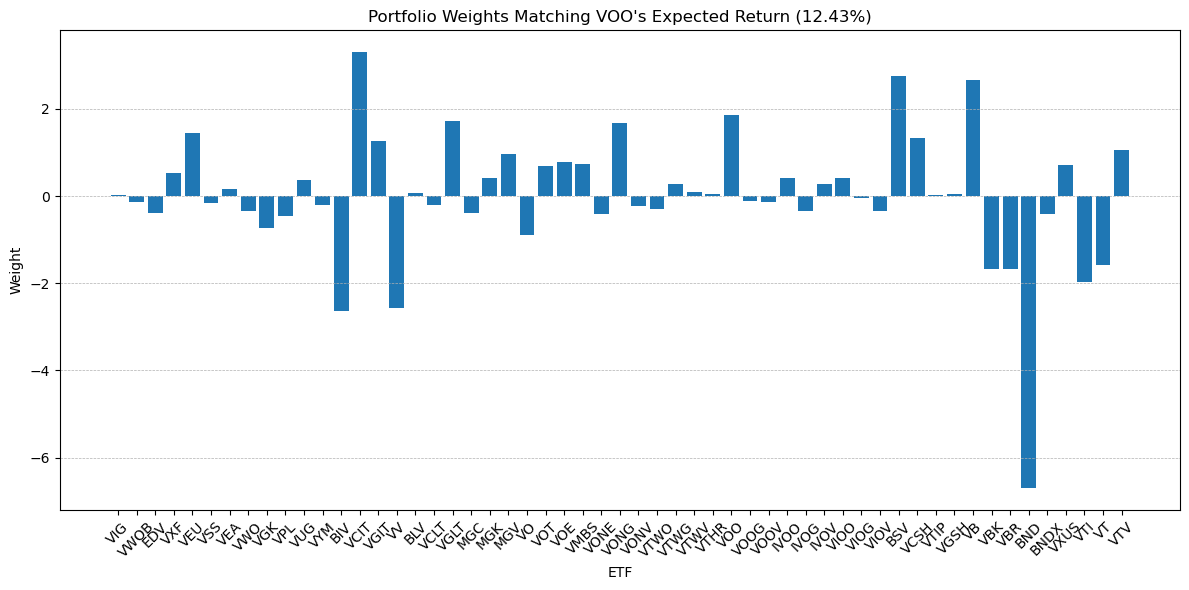

In [28]:
voo_returns_monthly = returns_monthly["VOO"]
voo_mu_annual = voo_returns_monthly.mean() * 12 - etf_expense_map.get("VOO", 0.0)
voo_sigma_annual = voo_returns_monthly.std() * np.sqrt(12)


def select_portfolio(frontier, target_metric, target_value):
    """
    Selects a portfolio from the efficient frontier closest to a target value.

    Args:
        frontier (dict): The efficient frontier dictionary.
        target_metric (str): The metric to match ('mu' or 'sigma').
        target_value (float): The target return or volatility.

    Returns:
        tuple: Index and weights of the selected portfolio, or (None, None).
    """
    if not frontier[target_metric]:
        return None, None
    diffs = np.abs(np.array(frontier[target_metric]) - target_value)
    idx = diffs.argmin()
    return idx, frontier["weights"][idx]

# Select matching portfolio
idx, weights_voo_match = select_portfolio(frontier_data, target_metric="mu", target_value=voo_mu_annual)

# Visualize the selected portfolio weights
if weights_voo_match is not None:
    selected_mu = frontier_data["mu"][idx]
    selected_sigma = frontier_data["sigma"][idx]

    print(f"\nComparison with VOO:")
    print(f"VOO - Expected Return: {voo_mu_annual:.2%}, Volatility: {voo_sigma_annual:.2%}")
    print(f"Selected Portfolio - Expected Return: {selected_mu:.2%}, Volatility: {selected_sigma:.2%}")

    # Zip symbols and weights, then sort by weight
    weights_named = list(zip(etf_symbols, weights_voo_match))
    sorted_weights = sorted(weights_named, key=lambda x: x[1], reverse=True)
    sorted_by_abs = sorted(weights_named, key=lambda x: abs(x[1]))

    print("\nTop 3 Weights in Selected Portfolio:")
    for symbol, weight in sorted_weights[:3]:
        print(f"{symbol}: {weight:.2%}")

    print("\nBottom 3 Weights in Selected Portfolio:")
    for symbol, weight in sorted_weights[-3:]:
        print(f"{symbol}: {weight:.2%}")

    print("\n3 Smallest Absolute Weights in Selected Portfolio:")
    for symbol, weight in sorted_by_abs[:3]:
        print(f"{symbol}: {weight:.2%}")


    plt.figure(figsize=(12, 6))
    plt.bar(etf_symbols, weights_voo_match)
    plt.title(f"Portfolio Weights Matching VOO's Expected Return ({voo_mu_annual:.2%})")
    plt.ylabel("Weight")
    plt.xlabel("ETF")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No matching portfolio found on the frontier.")




This is unfortunately a very typical result for portfolio optimization: the expected volatility for the optimal portfolio is much lower than for VOOs, but it is practically infeasible as there are many assets with extreme weights in the optimal portfolio.  BND, the Total Bond Market ETF, for example, should have a weight of more than -600%, while VCIT, the intermediate corporate bond ETF, should have a weight of more than 300%!  In other words, if you want to invest $1, you should short-sell $6 of BND and use the proceeds to purchase $3 of VCIT, etc.  This is not really feasible for the normal investors.  

We could also encounter a second problem: there are many portfolios with quite small weights, such as VTIP, the Short-Term Inflation-Protected Securities ETF, having a weight of just 2.5%.  This is not very large and it makes the implementation of trading strategies difficult if you have to purchase many ETFs with tiny weights.

A third problem we have not mentioned yet is estimation error.  Given how extreme the weights are, even small errors in the estimated expected return or the covariance matrix can lead to substantial changes in the optimal portfolio allocations.  


To account for the problem we have seen above, we can do the following
- **Add long-only constraints**: we can add additional constraints to make sure each portfolio weight is between zero and one.  This is much more realistic for an individual investor.

- **Apply L1 regularization**: we can adapt the idea from LASSO regression and add a penalty for large and non-zero weight, making it more likely that the optimization shrinks more weights to zero and reducing the number of components in the optimal portfolio.  We need to decide on a the meta-parameter for the penalty, lambda, which can do via a simple grid search.  Choosing to small of a lambda and we might have too many small ETFs in the optimal portfolio, choosing to large a lambda and we introduce too much of a bias and the portfolio is not optimal anymore.  So, let's look for the lambda that maximizes the Sharpe ratio, expected return over sigma, for the optimal portfolio that matches VOO's expected return.  The Sharpe ratio is a measure of the price of risk, so it makes sense to choose the highest possible return that we can get for one unit of risk, i.e., volatility.

- **Apply shrinkage methods to $\mu$ and $\sigma$**: To reduce the effect of estimation error in the expected return and the covariance matrix, we can apply shrinkage methods for both.  We can try James-Stein for the expected return and Ledoit-Wolf for the covariance matrix.  Both shrink the sample estimates to a reasonable target, thus reducing estimation error and noise of the estimates.  James-Stein shrinks to the sample mean of the ETFs to the grand mean over all ETFs, and Ledoit-Wolf shrink the covariance matrix to the identify matrix.

Thus, we can rewrite the optimization problem as follows, with $\mu$ and $\Sigma$ either as the sample mean and covariance, or by using shrinkage methods first.

#### Objective

$$
\min_{\mathbf{w}, \mathbf{u}} \quad \tfrac{1}{2} \mathbf{w}^\top \Sigma \mathbf{w} + \lambda \sum_{i=1}^n u_i
$$


#### Constraints

1. **L1 Reformulation (Enforce $ u_i \ge |w_i| $)**

$$
w_i - u_i \le 0 \quad \text{(i.e., } u_i \ge w_i \text{)}
$$

$$
-w_i - u_i \le 0 \quad \text{(i.e., } u_i \ge -w_i \text{)}
$$

2. **Long-only Constraints**

$$
0 \le w_i \le 1
$$

3. **Budget Constraint**

$$
\sum_{i=1}^n w_i = 1
$$

4. **Target Return Constraint**

$$
\sum_{i=1}^n w_i \mu_i = \mu^*
$$


In [29]:
def efficient_frontier(
    covariance_matrix, expected_returns, n_points=50, lambda_l1=0.0
):
    """
    Calculates the efficient frontier using the Markowitz model with optional L1
    regularization (LASSO). This encourages sparse portfolios by driving the
    weights of less important assets to exactly zero.

    This function reformulates the L1-regularized problem into a standard
    Quadratic Program (QP) that can be solved efficiently by CVXOPT.

    Args:
        covariance_matrix (np.array): Annualized covariance matrix of asset returns.
        expected_returns (np.array): Annualized vector of expected asset returns.
        n_points (int): The number of points to calculate along the frontier.
        lambda_l1 (float): The regularization strength. Higher values lead to
                           more sparsity (more zero weights).

    Returns:
        dict: A dictionary containing returns ('mu'), volatilities ('sigma'),
              and portfolio weights ('weights') for each point on the frontier.
    """
    n_assets = len(expected_returns)

    # We solve for a combined vector x = [w, u] of size 2*n_assets, where:
    # w: the standard portfolio weights (n_assets)
    # u: auxiliary variables to handle the absolute value |w_i| (n_assets)
    # The objective becomes: minimize 0.5*w'.Cov.w + lambda*1'.u
    # Subject to: w-u <= 0, -w-u <= 0 (which implies u >= |w|)

    # 1. The Quadratic Term P
    # Only involves 'w', so P_new has the original covariance_matrix in the
    # top-left block and zeros elsewhere.
    P_l1 = opt.matrix(
        np.block(
            [
                [covariance_matrix, np.zeros((n_assets, n_assets))],
                [np.zeros((n_assets, n_assets)), np.zeros((n_assets, n_assets))],
            ]
        )
    )

    # 2. The Linear Term q
    # The L1 penalty `lambda * sum(|w_i|)` is reformulated as `lambda * sum(u_i)`.
    # This becomes the linear part of the objective, q'.x.
    q_l1 = opt.matrix(np.concatenate([np.zeros(n_assets), lambda_l1 * np.ones(n_assets)]))

    # 3. The Inequality Constraints G and h (for Gx <= h)
    # These enforce u_i >= |w_i| and the original box constraints 0 <= w_i <= 1.
    I = np.eye(n_assets)
    Z = np.zeros((n_assets, n_assets))
    G_l1 = opt.matrix(
        np.block(
            [
                [I, -I],  # For w_i - u_i <= 0
                [-I, -I],  # For -w_i - u_i <= 0
                [-I, Z],  # For -w_i <= 0 (w_i >= 0)
                [I, Z],  # For w_i <= 1
            ]
        )
    )
    h_l1 = opt.matrix(np.concatenate([np.zeros(3 * n_assets), np.ones(n_assets)]))

    # 4. The Equality Constraints A and b (for Ax = b)
    # These constraints (sum of weights = 1, portfolio return = target)
    # only apply to the 'w' part of our variable vector 'x'.
    A_l1 = opt.matrix(
        np.block(
            [
                [expected_returns, np.zeros(n_assets)],
                [np.ones(n_assets), np.zeros(n_assets)],
            ]
        )
    )

    # Iterate through a range of target returns to trace the frontier
    target_mus = np.linspace(expected_returns.min(), expected_returns.max(), n_points)
    frontier = {"mu": [], "sigma": [], "weights": []}
    for target_mu in target_mus:
        # The RHS of the equality constraint
        b_l1 = opt.matrix([target_mu, 1.0])
        try:
            # Solve the larger, reformulated QP problem
            solution = opt.solvers.qp(P_l1, q_l1, G_l1, h_l1, A_l1, b_l1)
            if solution["status"] == "optimal":
                # Extract only the weights 'w' from the solution vector 'x'.
                weights = np.array(solution["x"][:n_assets]).flatten()
                # Clean up tiny weights due to solver precision
                weights[np.abs(weights) < 1e-7] = 0
                # Re-normalize to ensure sum is exactly 1 after cleanup
                if np.sum(weights) > 0:
                    weights /= np.sum(weights)

                sigma = np.sqrt(weights.T @ covariance_matrix @ weights)
                actual_mu = weights.T @ expected_returns
                frontier["mu"].append(actual_mu)
                frontier["sigma"].append(sigma)
                frontier["weights"].append(weights)
        except ValueError:
            # Solver may fail if no feasible solution exists for a target return
            pass
    return frontier


def prune_frontier(frontier):
    """
    Removes dominated portfolios from a mean-variance frontier, keeping only
    the efficient upper arm where return increases with volatility.

    Args:
        frontier (dict): A dict with keys 'sigma', 'mu', 'weights'.

    Returns:
        dict: A pruned frontier with the same structure.
    """
    vol = np.asarray(frontier["sigma"])
    ret = np.asarray(frontier["mu"])
    wlist = list(frontier["weights"])

    # 1) Sort by volatility (ascending)
    order = np.argsort(vol)
    vol, ret = vol[order], ret[order]
    wlist = [wlist[i] for i in order]

    # 2) Walk from left to right, keeping only points with strictly increasing returns
    keep_idx = []
    last_best_ret = -np.inf
    for i in range(len(ret)):
        if ret[i] > last_best_ret + 1e-12:
            keep_idx.append(i)
            last_best_ret = ret[i]

    # 3) Assemble the pruned frontier
    return {
        "sigma": vol[keep_idx].tolist(),
        "mu": ret[keep_idx].tolist(),
        "weights": [wlist[i] for i in keep_idx],
    }


#  Grid-Search for the "Best" L1-Penalty (lambda_1)
# - A simple train/validation split is used (last 20% = validation).
# - The metric for "best" is the out-of-sample Sharpe Ratio.
# - The portfolio on the frontier is chosen by matching VOO's volatility.
print("\n--- Grid-searching for optimal L1 penalty (lambda) ---")
lambda_grid = np.logspace(-6, -1, 11)  # 11 points: 1e-6 to 1e-1
val_frac = 0.20
target_sig = voo_mu_annual

# Split data into training and validation sets
T = len(returns_monthly)
split_idx = int((1 - val_frac) * T)
ret_train = returns_monthly.iloc[:split_idx]
ret_val = returns_monthly.iloc[split_idx:]

mu_train = ret_train.mean().values * 12
cov_train = ret_train.cov().values * 12
mu_val = ret_val.mean().values * 12
cov_val = ret_val.cov().values * 12


def sharpe_ratio(mu, sigma):
    """
    Calculates annualized Sharpe ratio from annualized decimal returns.
    (Assumes risk-free rate = 0).
    """
    return mu / sigma if sigma > 0 else np.nan


def eval_lambda(lam):
    """Fit frontier with lambda_1=lam on train-set, score on validation."""
    front = efficient_frontier(cov_train, mu_train, n_points=30, lambda_l1=lam)
    _, w = select_portfolio(front, "mu", target_sig)
    if w is None:
        return np.nan
    mu_out_of_sample = w @ mu_val
    sigma_out_of_sample = np.sqrt(w @ cov_val @ w)
    return sharpe_ratio(mu_out_of_sample, sigma_out_of_sample)


# Perform grid search
scores = [eval_lambda(lam) for lam in lambda_grid]
best_idx = int(np.nanargmax(scores))
best_lambda = float(lambda_grid[best_idx])

# Report results
print(f"lambda_1 candidates: {[f'{l:.5g}' for l in lambda_grid]}")
print(f"Validation Sharpe: {[f'{s:.3f}' for s in scores]}")
print(f"\n-> Selected optimal lambda_1 = {best_lambda:.5g}\n")



--- Grid-searching for optimal L1 penalty (lambda) ---
lambda_1 candidates: ['1e-06', '3.1623e-06', '1e-05', '3.1623e-05', '0.0001', '0.00031623', '0.001', '0.0031623', '0.01', '0.031623', '0.1']
Validation Sharpe: ['1.795', '1.795', '1.795', '1.795', '1.795', '1.795', '1.795', '1.795', '1.795', '1.795', '1.795']

-> Selected optimal lambda_1 = 0.031623



Before we implement models with shrinkage estimates for $\mu$ and $\Sigma$, we should see how they compare to the sample mean and covariance.

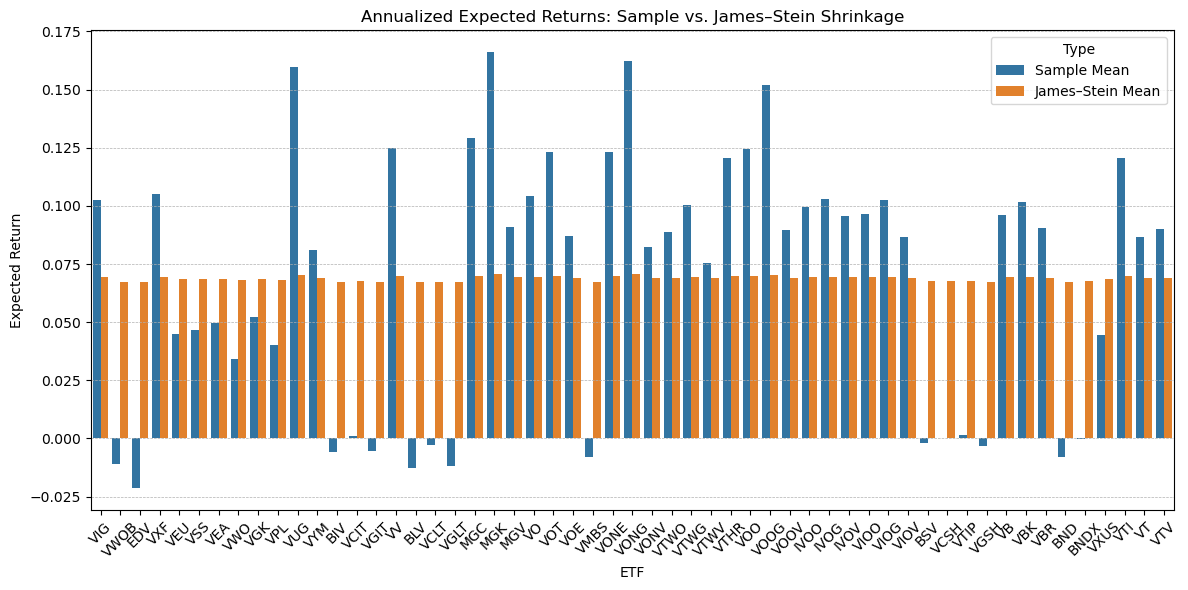

In [30]:
def james_stein_shrinkage(mu_hat):
    """
    Applies James–Stein shrinkage to the vector of sample means.

    Args:
        mu_hat (np.ndarray): Sample mean returns (shape: [n_assets]).

    Returns:
        np.ndarray: Shrunk mean returns.
    """
    p = len(mu_hat)
    mu_bar = np.mean(mu_hat)
    numerator = (p - 2) * np.var(mu_hat, ddof=1)
    denominator = np.sum((mu_hat - mu_bar) ** 2)
    
    # Guard against division by zero
    if denominator == 0:
        lambda_js = 0
    else:
        lambda_js = min(1, max(0, numerator / denominator))

    mu_shrunk = (1 - lambda_js) * mu_hat + lambda_js * mu_bar
    return mu_shrunk


# Mean shrinkage
annual_mu_shrunk = james_stein_shrinkage(annual_mu_sample)

# Covariance shrinkage
lw = LedoitWolf().fit(returns_monthly.values)
annual_cov_shrunk = lw.covariance_ * 12

# Create DataFrame for plotting
df_mu = pd.DataFrame({
    "ETF": etf_symbols,
    "Sample Mean": annual_mu_sample,
    "James–Stein Mean": annual_mu_shrunk
})

# Melt to long format for seaborn
df_mu_melted = df_mu.melt(id_vars="ETF", var_name="Type", value_name="Return")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mu_melted, x="ETF", y="Return", hue="Type")
plt.xticks(rotation=45)
plt.title("Annualized Expected Returns: Sample vs. James–Stein Shrinkage")
plt.ylabel("Expected Return")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


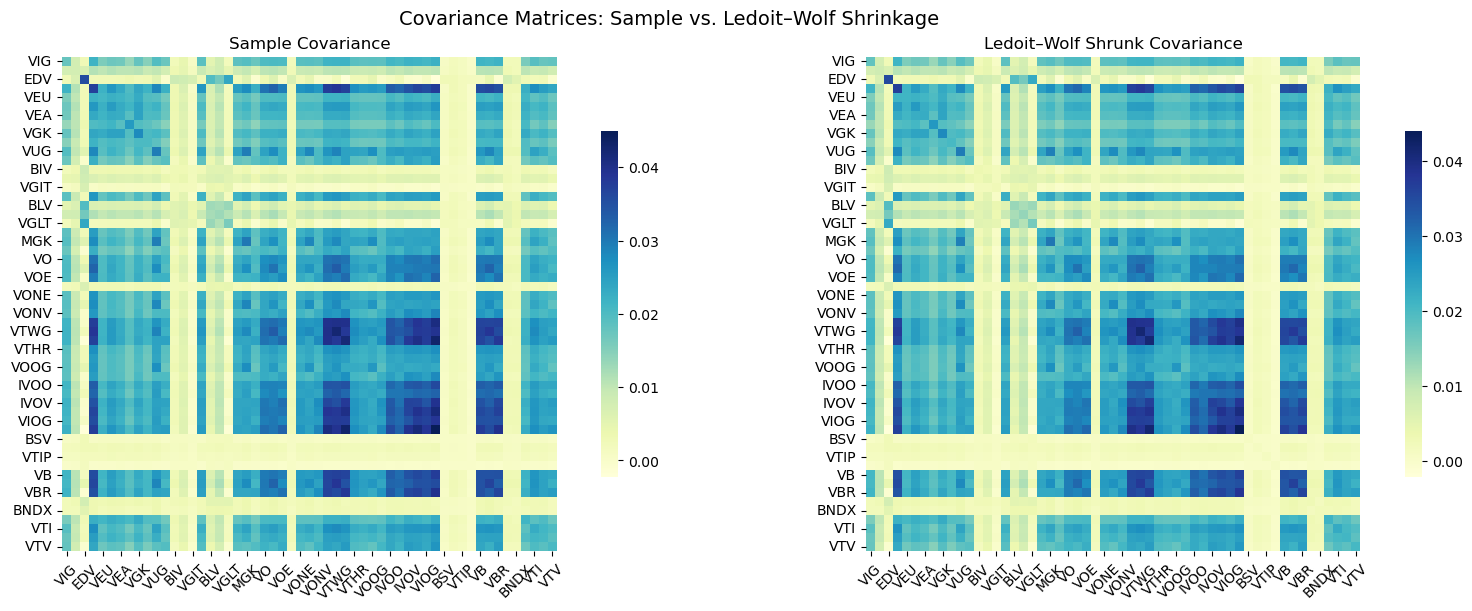

In [31]:
# Convert to DataFrames for heatmap comparison
df_cov_sample = pd.DataFrame(annual_cov_sample, index=etf_symbols, columns=etf_symbols)
df_cov_shrunk = pd.DataFrame(annual_cov_shrunk, index=etf_symbols, columns=etf_symbols)

# Plot side-by-side heatmaps
fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

sns.heatmap(df_cov_sample, cmap="YlGnBu", ax=axs[0], square=True, cbar_kws={"shrink": 0.7})
axs[0].set_title("Sample Covariance")

sns.heatmap(df_cov_shrunk, cmap="YlGnBu", ax=axs[1], square=True, cbar_kws={"shrink": 0.7})
axs[1].set_title("Ledoit–Wolf Shrunk Covariance")

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.suptitle("Covariance Matrices: Sample vs. Ledoit–Wolf Shrinkage", fontsize=14)
plt.show()

We see very different results: James-Stein is too aggressive and shrink the annual means of the ETFs to severely to the grand mean, while Ledoit-Wolf barely changes the covariance matrix.  I appears that since the sample means are no too widely distributed, James-Stein shrinks them relatively quickly towards the grand mean, while the sample covariance matrix is already quite stable due to the 120 observations going into its estimation, so Ledoit-Wolf does not change much.

Instead of the harsh shrinkage by James-Stein, let's use a more gentle shrinkage parameter, that preserves more of the dispersion of the expected returns.

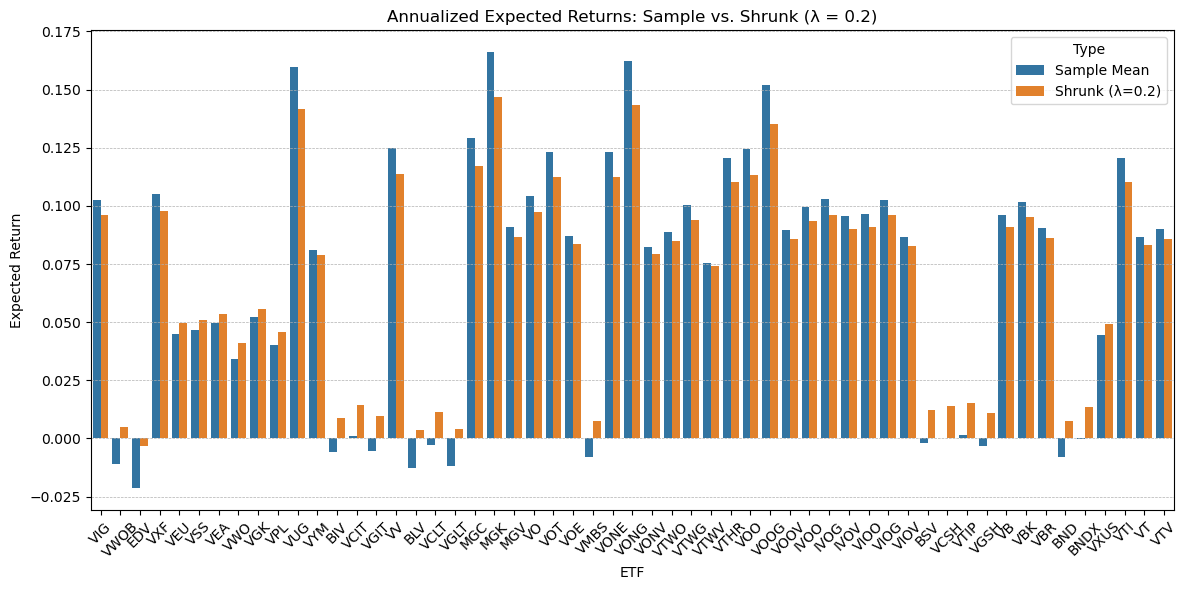

In [33]:
lambda_small = 0.2  # small shrinkage strength
mu_grand = np.mean(annual_mu_sample)
annual_mu_shrunk_partial = (1 - lambda_small) * annual_mu_sample + lambda_small * mu_grand

# Build DataFrame
df_mu_partial = pd.DataFrame({
    "ETF": etf_symbols,
    "Sample Mean": annual_mu_sample,
    f"Shrunk (λ={lambda_small})": annual_mu_shrunk_partial
})

# Melt to long format for plotting
df_mu_melted = df_mu_partial.melt(id_vars="ETF", var_name="Type", value_name="Return")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mu_melted, x="ETF", y="Return", hue="Type")
plt.xticks(rotation=45)
plt.title(f"Annualized Expected Returns: Sample vs. Shrunk (λ = {lambda_small})")
plt.ylabel("Expected Return")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Finally, let us generate the efficient frontiers and compare the portfolios for each efficient frontier that match VOO's expected mean or volatility.


Top 3 ETFs for Raw (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 76.98%
  VGSH (Short-Term Treasury ETF): 23.02%

Top 3 ETFs for Raw (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 88.54%
  VGSH (Short-Term Treasury ETF): 11.46%

Top 3 ETFs for L1 Regularized (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 68.32%
  VGSH (Short-Term Treasury ETF): 23.22%
  MGK (Mega Cap Growth ETF): 8.46%

Top 3 ETFs for L1 Regularized (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 77.58%
  VGSH (Short-Term Treasury ETF): 11.71%
  MGK (Mega Cap Growth ETF): 10.71%

Top 3 ETFs for Shrunk Covariance (Return-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 68.32%
  VGSH (Short-Term Treasury ETF): 23.22%
  MGK (Mega Cap Growth ETF): 8.46%

Top 3 ETFs for Shrunk Covariance (Risk-Matched) Portfolio:
  VONG (Russell 1000 Growth ETF): 77.58%
  VGSH (Short-Term Treasury ETF): 11.71%
  MGK (Mega Cap Growth ETF): 10.71%

Top 3 ETFs for Shrunk Mean (Retur

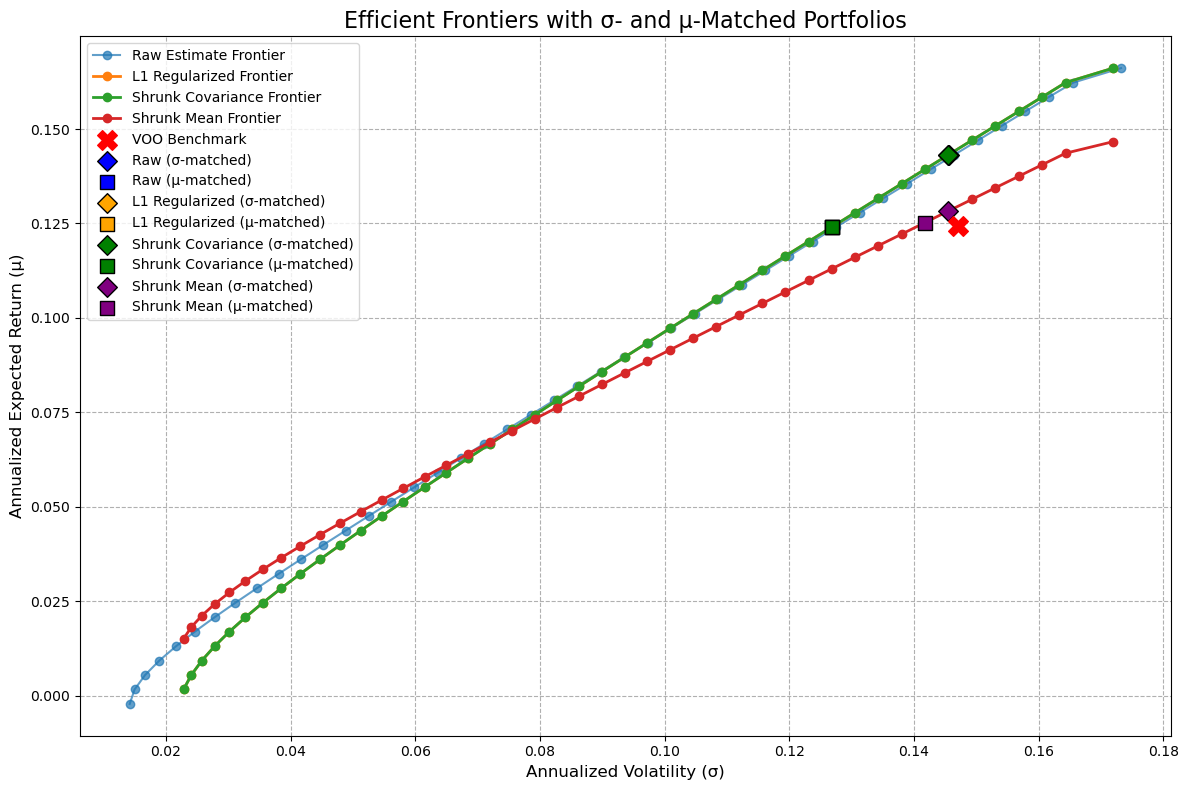

In [36]:
# Frontier using simple sample estimates
ef_raw = prune_frontier(
    efficient_frontier(annual_cov_sample, annual_mu_sample, n_points=FRONTIER_POINTS)
)
# Frontier using L1 regularization
ef_reg_l1 = prune_frontier(
    efficient_frontier(
        annual_cov_shrunk, annual_mu_sample, n_points=FRONTIER_POINTS, lambda_l1=best_lambda
    )
)
# Frontier using shrinkage-adjusted covariance
ef_shrunk = prune_frontier(
    efficient_frontier(annual_cov_shrunk, annual_mu_sample, n_points=FRONTIER_POINTS)
)
# Frontier using also shrinkage-adjusted means
ef_shrunk_mean = prune_frontier(
    efficient_frontier(annual_cov_shrunk, annual_mu_shrunk_partial, n_points=FRONTIER_POINTS)
)

# Find portfolios on each frontier matching the VOO benchmark's risk or return
_, w_mu_raw = select_portfolio(ef_raw, "mu", voo_mu_annual)
_, w_sigma_raw = select_portfolio(ef_raw, "sigma", voo_sigma_annual)
_, w_mu_reg_l1 = select_portfolio(ef_reg_l1, "mu", voo_mu_annual)
_, w_sigma_reg_l1 = select_portfolio(ef_reg_l1, "sigma", voo_sigma_annual)
_, w_mu_shrunk = select_portfolio(ef_shrunk, "mu", voo_mu_annual)
_, w_sigma_shrunk = select_portfolio(ef_shrunk, "sigma", voo_sigma_annual)
_, w_mu_shrunk_mean = select_portfolio(ef_shrunk_mean, "mu", voo_mu_annual)
_, w_sigma_shrunk_mean = select_portfolio(ef_shrunk_mean, "sigma", voo_sigma_annual)

# Display the composition of selected portfolios
portfolios_to_display = {
    "Raw (Return-Matched)": w_mu_raw,
    "Raw (Risk-Matched)": w_sigma_raw,
    "L1 Regularized (Return-Matched)": w_mu_reg_l1,
    "L1 Regularized (Risk-Matched)": w_sigma_reg_l1,
    "Shrunk Covariance (Return-Matched)": w_mu_shrunk,
    "Shrunk Covariance (Risk-Matched)": w_sigma_shrunk,
    "Shrunk Mean (Return-Matched)": w_mu_shrunk_mean,
    "Shrunk Mean (Risk-Matched)": w_sigma_shrunk_mean,
}

for label, weights in portfolios_to_display.items():
    if weights is not None:
        print(f"\nTop 3 ETFs for {label} Portfolio:")
        top_indices = np.argsort(weights)[-3:][::-1]
        for i in top_indices:
            if weights[i] > 0.001:  # Only show assets with meaningful weight
                symbol = etf_symbols[i]
                name = etf_name_map.get(symbol, "Unknown")
                print(f"  {symbol} ({name}): {weights[i]:.2%}")


# --- Plot Static Efficient Frontiers ---
plt.figure(figsize=(12, 8))
plt.plot(ef_raw["sigma"], ef_raw["mu"], "o-", label="Raw Estimate Frontier", alpha=0.7)
plt.plot(ef_reg_l1["sigma"], ef_reg_l1["mu"], "o-", label="L1 Regularized Frontier", lw=2)
plt.plot(
    ef_shrunk["sigma"], ef_shrunk["mu"], "o-", label="Shrunk Covariance Frontier", lw=2
)
plt.plot(
    ef_shrunk_mean["sigma"], ef_shrunk_mean["mu"], "o-", label="Shrunk Mean Frontier", lw=2
)
# VOO benchmark
plt.scatter([voo_sigma_annual], [voo_mu_annual], color="red", marker="X", s=200, label="VOO Benchmark", zorder=5)

# Define portfolio styles
portfolios = [
    ("Raw", w_sigma_raw, w_mu_raw, annual_mu_sample, "blue"),
    ("L1 Regularized", w_sigma_reg_l1, w_mu_reg_l1, annual_mu_sample, "orange"),
    ("Shrunk Covariance", w_sigma_shrunk, w_mu_shrunk, annual_mu_sample, "green"),
    ("Shrunk Mean", w_sigma_shrunk_mean, w_mu_shrunk_mean, annual_mu_shrunk_partial, "purple"),
]

# Plot sigma- and mu-matched portfolios
for label, w_sigma, w_mu, mu_vec, color in portfolios:
    if w_sigma is not None:
        mu = w_sigma @ mu_vec
        sigma = np.sqrt(w_sigma @ annual_cov_shrunk @ w_sigma)
        plt.scatter(sigma, mu, marker="D", color=color, edgecolor="black", s=100, label=f"{label} (σ-matched)", zorder=4)

    if w_mu is not None:
        mu = w_mu @ mu_vec
        sigma = np.sqrt(w_mu @ annual_cov_shrunk @ w_mu)
        plt.scatter(sigma, mu, marker="s", color=color, edgecolor="black", s=100, label=f"{label} (μ-matched)", zorder=4)

# Plot settings
plt.title("Efficient Frontiers with σ- and μ-Matched Portfolios", fontsize=16)
plt.xlabel("Annualized Volatility (σ)", fontsize=12)
plt.ylabel("Annualized Expected Return (μ)", fontsize=12)
plt.grid(True, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


The clearest results is that basically all efficient frontiers suggest to put almost 90% of my portfolio weight into Growth ETFs and the rest into the short-term treasury ETF to match VOO's volatility, and to match VOO's expected return to invest 3/4 into Growth ETFs and the rest into short term treasury.  This does make economic sense: short-term treasuries have low return, but also low volatility, while the Russel 1000 Growth ETFs has one of the highest returns in the sample, with also one of the highest volatility.  The short-term treasury ETF is also not very much correlated with other ETFs, so some combination of a Growth ETFs with high return/high volatility and a largely uncorrelated low return/low volatility treasury ETFs maximized the diversification potential while still matching VOO's return or risk.

Graphically, we see that all optimization variants perform quite similar, except for the mean-shrinkage method.  Ledoit-Wolf barely changes the covariance matrix, so it virtually delivers the same results as using the sample covariance.  Without regularization, only two ETFs are selected anyways, so we don't have an issue with many small weights.  The L1 regularization only penalizes the large weight on the Russel 1000 Growth ETFs and leads to the addition of a another Growth ETF instead, which overall doesn't change much as the Mega Cap Growth ETF has a similar risk-return profile as the Russel 1000 Growth ETF.

Mean shrinkage leads to generally inferior frontier estimates and perform worse than no shrinkage at all.  Since we have 120 monthly return estimates per ETF, the estimates for the mean should be quite reliable with such a large sample, so shrinkage might not be needed in the first place.  Thus, I will not consider mean-shrinkage further for now.  In later iteration, we might need to come back to mean-shrinkage if the out-of-sample performance for the portfolio optimization without is terrible.

Here is a nice little dashboard that allows to select points along the efficient frontier and calculated the optimal weights for that point.  As expected, only the weighting between the short term treasury and Growth ETF change, the more return/risk I am willing to accept, the more weight goes into the Growth ETF and vice versa.

In [46]:
import plotly.graph_objects as go
from ipywidgets import VBox, HTML
from IPython.display import display

sigmas   = np.array(ef_raw["sigma"])
mus      = np.array(ef_raw["mu"])
weights  = np.array(ef_raw["weights"])          # (n_points, n_assets)
symbols  = etf_symbols                          # ticker list
name_map = etf_name_map                         # dict ticker → long name

fig = go.FigureWidget()
fig.layout.hovermode = "closest"
fig.layout.clickmode = "event+select"

fig.add_scatter(x=sigmas, y=mus, mode="lines",
                line=dict(color="lightgray"), hoverinfo="skip", showlegend=False)

fig.add_scatter(
    x=sigmas,
    y=mus,
    mode="markers",
    marker=dict(size=10, color="black"),
    name="Raw Frontier",
    hovertemplate="σ: %{x:.2%}<br>μ: %{y:.2%}<br>(click to see top weights)<extra></extra>",
)

fig.update_layout(
    title="Efficient Frontier (Raw Estimates)",
    xaxis_title="Volatility (σ)",
    yaxis_title="Expected Return (μ)",
    height=480,
)

out = HTML()

def format_html(idx: int) -> str:
    """Return HTML string listing the three largest weights."""
    w = weights[idx]
    top_idx = np.argsort(w)[-3:][::-1]
    
    rows = []
    for i in top_idx:
        if w[i] > 0.001:  # ≥ 0.1 %
            sym  = symbols[i]
            name = name_map.get(sym, "Unknown")
            rows.append(
                f"<li><b>{sym}</b> <span style='color:#666'>({name})</span>"
                f"<span style='float:right'>{w[i]:.2%}</span></li>"
            )
    
    html = (
        f"<div style='font-family:Arial, sans-serif; font-size:14px;"
        f"line-height:1.4; max-width:420px;'>"
        f"<h4 style='margin:4px 0 8px 0; font-size:15px;'>"
        f"Top 3 ETFs – Frontier Point {idx+1}</h4>"
        f"<ul style='list-style:none; padding-left:0; margin:0;'>"
        + "\n".join(rows) +
        "</ul></div>"
    )
    return html

def show_top_three(idx: int):
    out.value = format_html(idx)

def handle_click(trace, points, selector):
    if points.point_inds:
        show_top_three(points.point_inds[0])

fig.data[1].on_click(handle_click)

display(VBox([fig, out]))


    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'lightgray'},…

### 4. Advanced Static Models & Robustness Checks

Extensions include:

* **Black–Litterman** (1992)
* **Risk Parity / Hierarchical Risk Parity** (Maillard et al., 2010; López de Prado, 2020)
* **Resampled Efficient Frontier** (Michaud, 1998)
* **DCC‑GARCH** (Engle, 2002)

#### Resampling observations - Boostrapping

Bootstrapped (resampled) tackles estimation risk by repeatedly drawing bootstrap samples of the historical return matrix, estimate the efficient frontier for each sample, and averaging the resulting weight vectors.  This Monte-Carlo overlay delivers two key benefits: robustness, because it dampens the impact of noisy single-sample estimates of $\mu$ and $\Sigma$, and diversification, because extreme corner solutions are naturally pulled toward the centre.  Given our ETF universe—only a decade of monthly data spread across many assets—resampling provides a pragmatic hedge against estimation error without forcing Bayesian prior. The trade-off is extra compute time and the risk of diluting genuine alpha if the true optimum is highly concentrated.  I am less worried about missing the optimum, but the computational burden leads me to only estimate 30 points for each efficient frontier.  For the optimal portfolio, I average across the bootstrapped optimal portfolios that match VOO's volatility. 

In [48]:
# Bootstrapping  addresses "estimation error" by creating many new return
# datasets via bootstrapping. The final portfolio is the average of all optimal
# portfolios found, leading to a more diversified and stable allocation.
print(f"Running Resampled Frontier with {RESAMPLE_ITERATIONS} iterations...")
n_obs, n_assets = returns_monthly.shape
resampled_weights_list = []

for i in range(RESAMPLE_ITERATIONS):
    if (i + 1) % 25 == 0:
        print(f"  Resample iteration {i + 1}/{RESAMPLE_ITERATIONS}...")

    # Create a bootstrap sample of the monthly returns
    boot_indices = np.random.choice(n_obs, size=n_obs, replace=True)
    returns_boot = returns_monthly.iloc[boot_indices]

    # Recalculate parameters for the bootstrap sample
    mu_boot = (returns_boot.mean().values * 12) - expense_vector
    try:
        # Use shrunk covariance for better stability in each resampled data set
        cov_boot = LedoitWolf().fit(returns_boot.values).covariance_ * 12
        # Generate frontier and select the risk-matched portfolio
        ef_boot = efficient_frontier(cov_boot, mu_boot, n_points=30)
        _, w_boot = select_portfolio(ef_boot, "sigma", voo_sigma_annual)
        if w_boot is not None:
            resampled_weights_list.append(w_boot)
    except (ValueError, np.linalg.LinAlgError):
        # Skip iteration if the solver or covariance estimation fails
        continue

# The final resampled portfolio is the average of weights from all iterations
if resampled_weights_list:
    w_resampled = np.mean(resampled_weights_list, axis=0)
    w_resampled /= w_resampled.sum()           # <-- ensures Σw = 1
    
    print("\nTop 3 ETFs for Resampled Portfolio:")
    top_indices = np.argsort(w_resampled)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {w_resampled[i]:.2%}")
else:
    w_resampled = None
    print("\nCould not generate a resampled portfolio.")


Running Resampled Frontier with 100 iterations...
  Resample iteration 25/100...
  Resample iteration 50/100...
  Resample iteration 75/100...
  Resample iteration 100/100...

Top 3 ETFs for Resampled Portfolio:
  VONG (Russell 1000 Growth ETF): 32.30%
  MGK (Mega Cap Growth ETF): 25.05%
  EDV (Extended Duration Treasury ETF): 12.59%


Across the bootstrapped optimal portfolios, we actually get a pretty similar results as for the static optimization: we should invest most of our assets into growth ETFs and some into treasury ETFs. 

#### Rolling estimations

Next, we can check how the efficient frontier estimates change over time.  Ideally, the optimal portfolios are not very sensitive over time, so we don't have to frequently re-balance. 

This rolling-window exercise re-estimates the mean–variance optimizer every month using the most recent 60 months of data and select in for each window the optimal portfolio that matches VOO's volatility.  Plotting the time-series of the top-3 ETFs reveals how sensitive the strategy is to new information: a stable profile indicates robustness and low turnover, while sharp oscillations indicate that the efficient frontier is quite sensitive to which historic data go into the model and for what period it is estimated.  

For this mode, since we use fewer observations for estimating the covariance matrix, Ledoit-Wolf covariance helps reduce the resulting sampling noise.  I still use the rolling sample mean for optimization as the shrinkage results for the overall sample performed quite poorly.

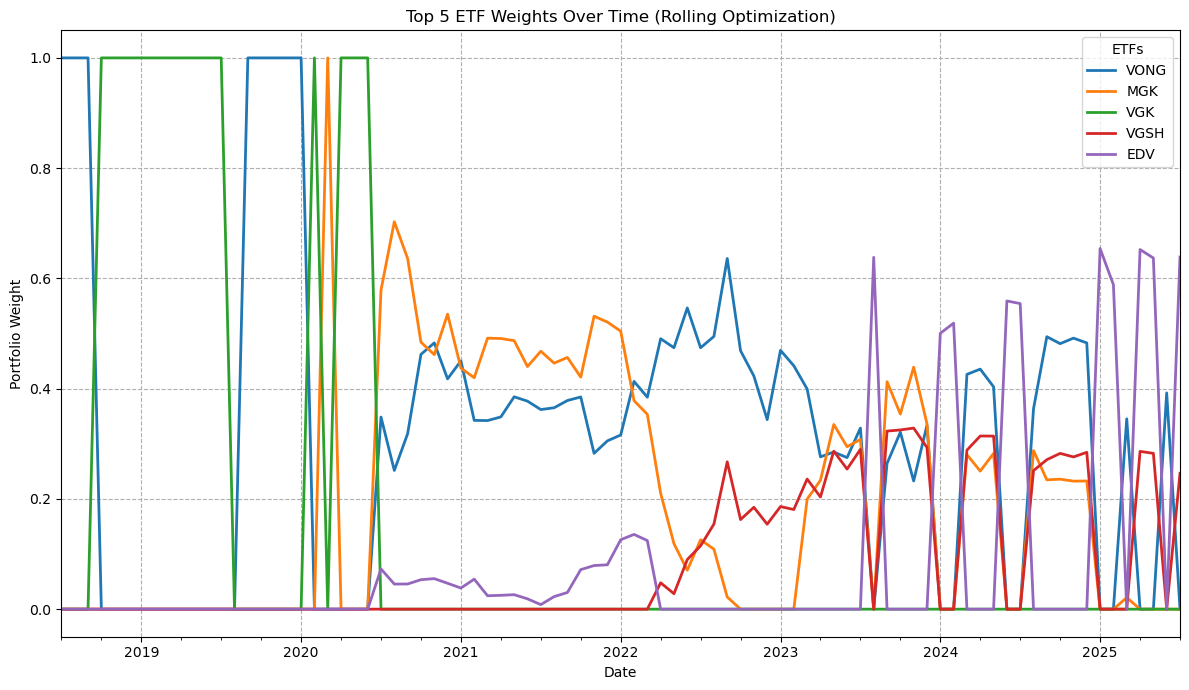

In [50]:
# This analysis shows how the optimal allocation would have changed over time,
# providing insight into the strategy's stability.
rolling_dates = returns_monthly.index[ROLLING_WINDOW_MONTHS:]
rolling_weights_list = []

for date in rolling_dates:
    # Create a data window of the last N months
    window_data = returns_monthly.loc[:date].iloc[-ROLLING_WINDOW_MONTHS:]
    # Estimate parameters on the window
    mu_roll = (window_data.mean().values * 12) - expense_vector
    cov_roll = LedoitWolf().fit(window_data.values).covariance_ * 12
    try:
        # Find the optimal (risk-matched) portfolio for this period
        ef_roll = efficient_frontier(cov_roll, mu_roll, n_points=30)
        _, w_roll = select_portfolio(ef_roll, "sigma", voo_sigma_annual)
        if w_roll is not None:
            rolling_weights_list.append(pd.Series(w_roll, index=etf_symbols, name=date))
    except (ValueError, np.linalg.LinAlgError):
        continue

# Combine results and plot the weight changes for the most important assets
if rolling_weights_list:
    rolling_weights_df = pd.concat(rolling_weights_list, axis=1).T
    # Identify the top 5 ETFs by average weight over time
    top_etfs = rolling_weights_df.mean().sort_values(ascending=False).head(5).index
    rolling_weights_df[top_etfs].plot(
        figsize=(12, 7), title="Top 5 ETF Weights Over Time (Rolling Optimization)", lw=2
    )
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Date")
    plt.grid(True, linestyle="--")
    plt.legend(title="ETFs")
    plt.tight_layout()
    plt.show()

The results are quite sobering.  The weights move around quite a lot.  However, the broad strokes are similar to the static optimization as VONG, Russell 1000 Growth ETF, and MGK, the Mega Cap Growth ETF, are frequently the top weighted funds.  EDV, the extended duration treasury ETF, becomes more popular since mid 2023, which makes sense following the interest rate increase during that period.  

#### Black-Litterman

Black–Litterman is a popular Bayesian portfolio construction framework.   Black–Littermann begins with market-implied equilibrium returns (the “prior”) and then tilts them toward investor views, producing a posterior return vector that is both economically grounded and data-driven.  

In my implementation the prior is a shrunk blend of the sample mean and the grand mean, very similar to what we tried above.  It is a light-touch Bayesian shrinkage, and we can allow for even more flexibility by running grid search to find the best shrinkage parameter.  In terms of investor views, I want to impose no specific assumptions, like by how much a specific ETFs outperforms the rest, but rather an economically defensible approach: the ETFs excess returns are approximately equal to VOO’s.  This makes sense if VOO is close to the market portfolio, the the remaining ETFs should eventually perform about as good as the market in the long run.  Uncertainty in the prior (tau_prior) and in the views (omega_scale) is are hyper-parameters as well that we can tune through a grid search, just as with the shrinkage parameter.  The objective also here should make economic sense and I chose again the parameter combination that maximizes the Sharpe ratio. 

In [51]:
# The Black-Litterman model starts with market-implied equilibrium returns and
# then tilts them based on an investor's specific views, creating a blended,
# more intuitive set of expected returns for optimization.
def run_black_litterman(
    shrink_factor=0.3, tau_prior=0.20, omega_scale=0.02, print_summary=True
):
    """
    Performs Black-Litterman optimization with tunable hyperparameters.

    Args:
        shrink_factor (float): Weight on the sample mean in the prior;
                               1-shrink_factor goes to the grand mean.
        tau_prior (float): Prior uncertainty scale. Larger => prior is less certain.
        omega_scale (float): Diagonal element for Omega matrix (view uncertainty).
                             Larger => views are softer/less binding.
        print_summary (bool): If True, prints portfolio weights and top holdings.

    Returns:
        tuple: (weights_bl, mu_posterior)
               - weights_bl (np.ndarray | None): Optimal long-only weights.
               - mu_posterior (np.ndarray | None): Posterior expected-return vector.
    """
    n_assets = len(etf_symbols)
    # 1. Prior mean (pi) - a blend of sample mean and grand mean
    grand_mean = annual_mu_sample.mean()
    prior_mean = shrink_factor * annual_mu_sample + (1 - shrink_factor) * grand_mean

    try:
        # 2. Investor view: each ETF's return is approximately equal to VOO's return
        idx_voo = etf_symbols.index("VOO")
        other_symbols = [sym for sym in etf_symbols if sym != "VOO"]
        # P matrix selects assets involved in the view
        P = np.zeros((len(other_symbols), n_assets))
        for k, sym in enumerate(other_symbols):
            P[k, returns_monthly.columns.get_loc(sym)] = 1  # +1 on ETF
            P[k, idx_voo] = -1  # -1 on VOO
        # Q vector contains the expected outperformance ("approximately 0" in this case)
        Q = np.zeros(len(other_symbols))

        # 3. View-uncertainty (Omega)
        Omega = np.diag(np.full(len(Q), omega_scale))

        # 4. Posterior mean calculation (core Black-Litterman formula)
        inv_cov_prior = np.linalg.inv(tau_prior * annual_cov_shrunk)
        inv_Omega = np.linalg.inv(Omega)
        middle = np.linalg.inv(inv_cov_prior + P.T @ inv_Omega @ P)
        mu_posterior = middle @ (inv_cov_prior @ prior_mean + P.T @ inv_Omega @ Q)

        # 5. Optimize portfolio (mean-variance) using the posterior returns
        P_qp = opt.matrix(annual_cov_shrunk)
        q_qp = opt.matrix(-mu_posterior)
        G_qp = opt.matrix(-np.eye(n_assets))  # w >= 0
        h_qp = opt.matrix(np.zeros(n_assets))
        A_qp = opt.matrix(np.ones((1, n_assets)))  # sum(w) = 1
        b_qp = opt.matrix(1.0)

        sol = opt.solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
        if sol["status"] != "optimal":
            raise RuntimeError(f"CVXOPT failed: {sol['status']}")

        weights_bl = np.array(sol["x"]).ravel()
        weights_bl[weights_bl < 1e-7] = 0
        weights_bl /= weights_bl.sum()

        if print_summary:
            print(
                f"\n--- Black-Litterman (shrink={shrink_factor}, "
                f"tau={tau_prior}, omega={omega_scale}) ---"
            )
            print("Weights > 1%:")
            for i, w in enumerate(weights_bl):
                if w > 0.01:
                    print(f"  {etf_symbols[i]}: {w:.1%}")
            top_idx = weights_bl.argsort()[-3:][::-1]
            print("\nTop 3 ETFs:")
            for i in top_idx:
                sym = etf_symbols[i]
                name = etf_name_map.get(sym, "Unknown")
                print(f"  {sym} ({name}): {weights_bl[i]:.2%}")

        return weights_bl, mu_posterior

    except (ValueError, IndexError, np.linalg.LinAlgError) as e:
        if print_summary:
            print(f"Black-Litterman failed: could not locate VOO or matrix error. {e}")
        return None, None


# ------------------------------------------------------------------------------
#  Hyperparameter Grid Search for Black-Litterman
# ------------------------------------------------------------------------------
print("\n--- Tuning Black-Litterman Hyperparameters ---")
shrink_grid = [0.2, 0.4, 0.6, 0.8]
tau_grid = [0.05, 0.10, 0.20, 0.30, 0.40]
omega_grid = [0.005, 0.01, 0.02, 0.05]
records = []

for shrink in shrink_grid:
    for tau in tau_grid:
        for omega in omega_grid:
            w, mu_post = run_black_litterman(shrink, tau, omega, print_summary=False)
            if w is None:
                continue
            exp_ret = float(w @ mu_post)
            vol = float(np.sqrt(w @ annual_cov_shrunk @ w))
            sharpe = exp_ret / vol if vol else np.nan
            records.append(
                {
                    "shrink": shrink,
                    "tau": tau,
                    "omega": omega,
                    "exp_return": exp_ret,
                    "vol": vol,
                    "sharpe": sharpe,
                    "top_weight": w.max(),
                    "assets_>1pct": (w > 0.01).sum(),
                }
            )

tune_df = pd.DataFrame(records).sort_values("sharpe", ascending=False)
print("Tuning results (top 10 by in-sample Sharpe):")
print(tune_df.head(10))
# ------------------------------------------------------------------------------

# Rerun with the best parameters found and print a summary
print("\n--- Final Black-Litterman Portfolio (using best tuned parameters) ---")
best_row = tune_df.iloc[0]
w_bl_opt, mu_bl = run_black_litterman(
    best_row["shrink"], best_row["tau"], best_row["omega"], print_summary=True
)


--- Tuning Black-Litterman Hyperparameters ---
Tuning results (top 10 by in-sample Sharpe):
    shrink   tau  omega  exp_return   vol  sharpe  top_weight  assets_>1pct
16   0.200 0.400  0.005       0.056 0.036   1.559       0.344             4
12   0.200 0.300  0.005       0.056 0.038   1.460       0.312             4
17   0.200 0.400  0.010       0.056 0.043   1.304       0.290             4
8    0.200 0.200  0.005       0.056 0.043   1.304       0.290             4
13   0.200 0.300  0.010       0.057 0.048   1.189       0.296             4
18   0.200 0.400  0.020       0.058 0.056   1.028       0.304             4
4    0.200 0.100  0.005       0.058 0.056   1.028       0.304             4
9    0.200 0.200  0.010       0.058 0.056   1.028       0.304             4
14   0.200 0.300  0.020       0.058 0.063   0.923       0.356             4
0    0.200 0.050  0.005       0.060 0.076   0.793       0.442             4

--- Final Black-Litterman Portfolio (using best tuned parameters) ---


These results look quite different: while we again have a combination of treasury ETFs and Growth ETFs, Black-Litterman clearly prefers to put much weight into treasuries.  This makes sense as we shrink the means of ETFs towards the market return, the posterior returns are quite similar and Black-Litterman only cares about minimizing portfolio volatility, exactly what treasury ETFs provide.  

Btw, enforcing for this setting minimum returns, like optimal portfolios should deliver at least 80% of VOO's expected return, frequently leads to the algorithm not converging.  Mean shrinkage might make it infeasible to reach higher expected returns. 

#### Risk Parity

Risk Parity builds a portfolio in which each ETF contributes the same percentage to total volatility, intentionally ignoring expected returns.  This “equal-risk” stance delivers two practical benefits: (i) diversification that is easy to explain to non-quants: no single asset can dominate portfolio risk—and (ii) robustness to return-forecast error.  The trade-offs is that in can overweight low-volatility assets and under-deliver on absolute return.  The code implements the idea by (1) computing marginal risk contributions, (2) minimising the squared deviation of each asset’s risk share from the equal-split target, and (3) enforcing long-only, fully­-invested weights. 

In [52]:
# Risk Parity aims to construct a portfolio where each asset contributes equally
# to the total portfolio risk. It ignores expected returns.
def portfolio_volatility(weights, cov_matrix):
    """Calculates the annualized volatility of a portfolio."""
    return np.sqrt(weights.T @ cov_matrix @ weights)


def risk_contributions(weights, cov_matrix):
    """Calculates each asset's percentage contribution to total portfolio risk."""
    port_vol = portfolio_volatility(weights, cov_matrix)
    if port_vol == 0:
        return np.zeros_like(weights)
    # Marginal Risk Contribution (MRC) = (Cov * w) / sigma_p
    mrc = (cov_matrix @ weights) / port_vol
    # Total Risk Contribution = w_i * MRC_i
    return weights * mrc


def risk_parity_objective(weights, cov_matrix):
    """
    Objective function for the optimizer. It seeks to minimize the
    variance of risk contributions across all assets, forcing them to be equal.
    """
    total_risk_contribs = risk_contributions(weights, cov_matrix)
    # Target is an equal contribution from each asset
    target_contribution = total_risk_contribs.sum() / len(weights)
    # Minimize the squared differences from this target
    return np.sum((total_risk_contribs - target_contribution) ** 2)


# Solve the optimization problem
initial_weights = np.ones(n_assets) / n_assets
bounds = tuple((0.0, 1.0) for _ in range(n_assets))
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}

result = minimize(
    fun=risk_parity_objective,
    x0=initial_weights,
    args=(annual_cov_sample,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    options={"disp": False},
)

rp_weights = result.x if result.success else None
if rp_weights is not None:
    print("Optimal Risk Parity Portfolio (weights > 1%):")
    for i, weight in enumerate(rp_weights):
        if weight > 0.01:
            print(f"  - {etf_symbols[i]}: {weight:.1%}")
    print("\nTop 3 ETFs for Risk Parity Portfolio:")
    top_indices = np.argsort(rp_weights)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {rp_weights[i]:.2%}")
else:
    print("Risk Parity optimization failed.")

Optimal Risk Parity Portfolio (weights > 1%):
  - VIG: 1.7%
  - VWOB: 3.2%
  - EDV: 3.8%
  - VXF: 1.1%
  - VEU: 1.5%
  - VSS: 1.2%
  - VEA: 1.4%
  - VWO: 1.8%
  - VGK: 1.2%
  - VPL: 1.7%
  - VUG: 1.1%
  - VYM: 1.7%
  - BIV: 3.5%
  - VCIT: 3.5%
  - VGIT: 3.1%
  - VV: 1.3%
  - BLV: 3.6%
  - VCLT: 3.1%
  - VGLT: 3.7%
  - MGC: 1.3%
  - MGK: 1.1%
  - MGV: 1.7%
  - VO: 1.0%
  - VOE: 1.1%
  - VMBS: 3.4%
  - VONE: 1.2%
  - VONG: 1.2%
  - VONV: 1.3%
  - VTWO: 1.1%
  - VTWG: 1.1%
  - VTWV: 1.1%
  - VTHR: 1.2%
  - VOO: 1.3%
  - VOOG: 1.2%
  - VOOV: 1.4%
  - IVOO: 1.0%
  - IVOG: 1.0%
  - IVOV: 1.1%
  - VIOO: 1.1%
  - VIOG: 1.1%
  - VIOV: 1.2%
  - BSV: 3.0%
  - VCSH: 3.2%
  - VTIP: 3.1%
  - VGSH: 2.7%
  - VB: 1.1%
  - VBK: 1.0%
  - VBR: 1.1%
  - BND: 3.4%
  - BNDX: 3.3%
  - VXUS: 1.5%
  - VTI: 1.2%
  - VT: 1.3%
  - VTV: 1.6%

Top 3 ETFs for Risk Parity Portfolio:
  EDV (Extended Duration Treasury ETF): 3.85%
  VGLT (Long-Term Treasury ETF): 3.71%
  BLV (Long-Term Bond ETF): 3.58%


As risk parity tries to distribute the risk across portfolio assets, we get many small weights across a lot of ETFs.  But it also seems that the highest weights go again to the low-volatility treasury ETFs, not great for expected returns.  We could implement something like L1 regularization also here to penalize small weights, but it likely would not lead to less weight on treasury ETFs, they are low-volatility and will have large weights.

#### Hierarchical Risk Parity (HRP)

Hierarchical Risk Parity (HRP) is a machine-learning-inspired take on risk parity portfolio optimization.  It follows a three-step, graph-theoretic workflow: (1) it converts the correlation matrix to a distance matrix and performs hierarchical clustering to group strongly related ETFs; (2) it re-orders (quasi-diagonalises) the covariance matrix so that similar assets sit next to each other; and (3) it applies a recursive bisection algorithm that splits the ordered list in halves and allocates capital inversely to each sub-cluster’s variance.  The result is a portfolio that automatically diversifies across statistically distinct clusters without estimating expected returns.  

One big advantage of this method is that is allows to a visual representation of the clusters via a dendrogram.  The disadvantage of the method is that is also will weight heavily on low volatility portfolios in clusters with low volatility.  What we can do, though, is to leverage this to our advantage and improve on the two-asset allocation we found through the static optimization.  We can take the portfolio that we found that matches VOO's volatility from the static optimization above (which mostly consists of Growth ETFs) and blend it with the optimal portfolio from HRP, which will have lower volatility and lower expected return, to match VOO's expected return.  Basically, we can find with this method a better low-volatility portfolio than the treasury ETF we found from the static portfolio optimization.

Optimal HRP Portfolio (weights > 1%):
  - BIV: 1.3%
  - VCIT: 1.7%
  - VGIT: 2.4%
  - VMBS: 2.6%
  - BSV: 10.1%
  - VCSH: 11.1%
  - VTIP: 10.3%
  - VGSH: 47.9%
  - BND: 1.7%
  - BNDX: 4.5%

Top 3 ETFs for HRP Portfolio:
  VGSH (Short-Term Treasury ETF): 47.86%
  VCSH (Short-Term Corporate Bond ETF): 11.11%
  VTIP (Short-Term Inflation-Protected Securities ETF): 10.33%


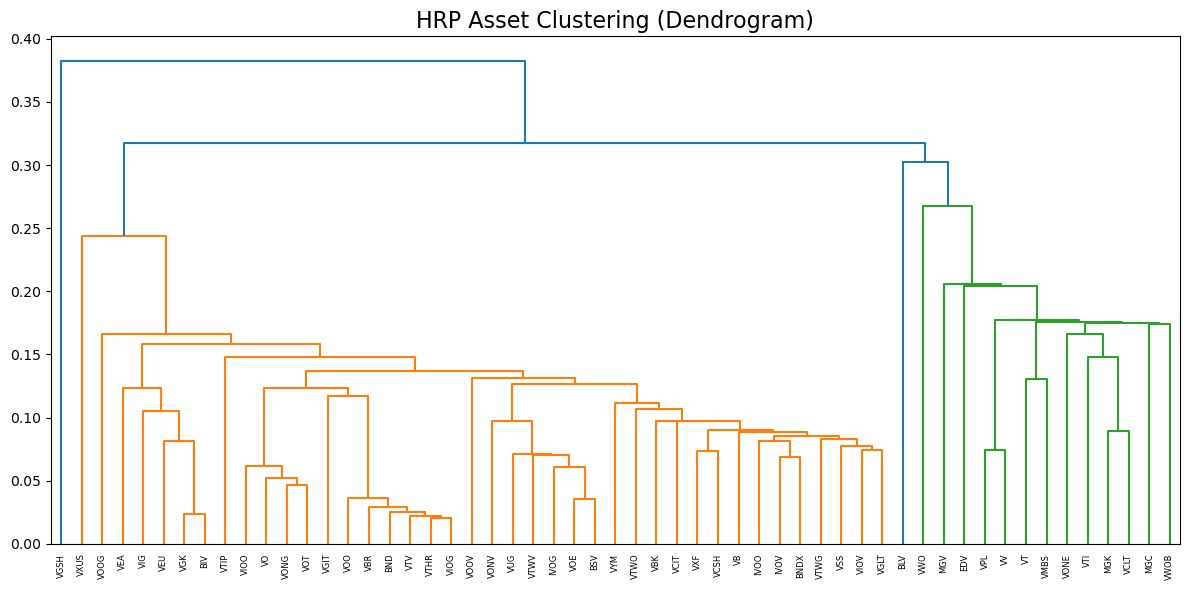


Blended HRP-MVO portfolio: alpha = 0.867
  Expected mu   = 12.43% (VOO: 12.43%)
  Volatility sigma = 12.88% (VOO: 14.70%)

Top 3 ETFs for Blended HRP-MVO Portfolio:
  VONG (Russell 1000 Growth ETF): 76.79%
  VGSH (Short-Term Treasury ETF): 16.29%
  VCSH (Short-Term Corporate Bond ETF): 1.48%


In [53]:
# HRP uses graph theory and machine learning to build a diversified portfolio.
# It clusters assets, reorders the covariance matrix, and allocates weights recursively.
def correlation_to_distance(corr_matrix):
    """Converts a correlation matrix to a distance matrix."""
    return np.sqrt(0.5 * (1 - corr_matrix))


def get_cluster_variance(cov_matrix, cluster_indices):
    """Calculates the variance of a cluster of assets."""
    sub_cov = cov_matrix[np.ix_(cluster_indices, cluster_indices)]
    # Inverse variance weights within the cluster
    inv_var_weights = 1.0 / np.diag(sub_cov)
    inv_var_weights /= inv_var_weights.sum()
    return inv_var_weights.T @ sub_cov @ inv_var_weights


def recursive_bisection(cov_matrix, sorted_indices):
    """Recursively splits weights between asset clusters."""
    weights = pd.Series(1.0, index=sorted_indices)
    clusters = [sorted_indices]
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) <= 1:
            continue
        # Bisect the cluster
        split_point = len(cluster) // 2
        left_cluster, right_cluster = cluster[:split_point], cluster[split_point:]
        # Calculate variance for each sub-cluster
        var_left = get_cluster_variance(cov_matrix, left_cluster)
        var_right = get_cluster_variance(cov_matrix, right_cluster)
        # Allocate weights inversely to cluster variance
        alpha = 1.0 - var_left / (var_left + var_right)
        weights[left_cluster] *= alpha
        weights[right_cluster] *= 1.0 - alpha
        # Add the new sub-clusters to the list to be processed
        clusters.extend([left_cluster, right_cluster])
    return weights.sort_index()


# Step 1: Hierarchical Clustering
corr_matrix = returns_monthly.corr()
dist_matrix = correlation_to_distance(corr_matrix)
linkage_matrix = linkage(squareform(dist_matrix), method="single")

# Step 2: Quasi-Diagonalization (Seriation)
# This reorders assets to place similar assets next to each other.
sorted_indices = leaves_list(linkage_matrix)
sorted_tickers = [etf_symbols[i] for i in sorted_indices]

# Step 3: Recursive Bisection
sorted_cov = returns_monthly[sorted_tickers].cov().values * 12
hrp_weights_sorted = recursive_bisection(sorted_cov, np.arange(len(sorted_tickers)))

# Map weights back to the original order of etf_symbols
hrp_weights = np.zeros(n_assets)
for i, ticker in enumerate(sorted_tickers):
    original_idx = etf_symbols.index(ticker)
    hrp_weights[original_idx] = hrp_weights_sorted.iloc[i]

print("Optimal HRP Portfolio (weights > 1%):")
for i, weight in enumerate(hrp_weights):
    if weight > 0.01:
        print(f"  - {etf_symbols[i]}: {weight:.1%}")

if hrp_weights is not None:
    print("\nTop 3 ETFs for HRP Portfolio:")
    top_indices = np.argsort(hrp_weights)[-3:][::-1]
    for i in top_indices:
        symbol = etf_symbols[i]
        name = etf_name_map.get(symbol, "Unknown")
        print(f"  {symbol} ({name}): {hrp_weights[i]:.2%}")

# Optional: Visualize the asset hierarchy with a dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=sorted_tickers, leaf_rotation=90)
plt.title("HRP Asset Clustering (Dendrogram)", fontsize=16)
plt.tight_layout()
plt.show()

# Blend the HRP portfolio with the MVO portfolio (risk-matched to VOO)
# to create a new portfolio that meets VOO's expected return.
mu_hrp = hrp_weights @ annual_mu_sample
mu_mv = w_sigma_raw @ annual_mu_sample
# Calculate blending factor 'alpha'
alpha = np.clip((voo_mu_annual - mu_hrp) / (mu_mv - mu_hrp + 1e-12), 0, 1)
# Create blended weights
w_tilt = (1 - alpha) * hrp_weights + alpha * w_sigma_raw
w_tilt /= w_tilt.sum()
sigma_tilt = np.sqrt(w_tilt @ annual_cov_sample @ w_tilt)

print(f"\nBlended HRP-MVO portfolio: alpha = {alpha:.3f}")
print(f"  Expected mu   = {w_tilt @ annual_mu:.2%} (VOO: {voo_mu_annual:.2%})")
print(f"  Volatility sigma = {sigma_tilt:.2%} (VOO: {voo_sigma_annual:.2%})")
print("\nTop 3 ETFs for Blended HRP-MVO Portfolio:")
top_indices = np.argsort(w_tilt)[-3:][::-1]
for i in top_indices:
    symbol = etf_symbols[i]
    name = etf_name_map.get(symbol, "Unknown")
    print(f"  {symbol} ({name}): {w_tilt[i]:.2%}")

As expected, the blended portfolio weighs heavily on the Russell 1000 Growth ETF, but now blends in, for example, the short-term corporate bonds ETFs as low-volatility component.

The dendrogram shows quite interesting risk clusters.  There are apparently two large clusters, with the right cluster including, for example, all the Mega Cap ETFs, Total Market Stock ETF, but also the extended duration treasury ETF.  Apparently, the closest ETFs to the Mega Cap Growth ETFs, MGK, in terms of volatility is VCLT, Long-Term Corporate Bond ETF, quite unexpected, and for the Russell 1000 Growth ETF, VONG, it is VOT, Mid-Cap Growth ETF, which is a bit less unexpected.

#### DCC-GARCH

Let's try to find optimal portfolios accounting for changing volatility and covariance over time.  Dynamic Conditional Correlation (DCC)-GARCH extends classic GARCH by allowing both volatilities and cross-asset correlations to evolve over time.  This method allows us to model and predict the covariance matrix in a more dynamic fashion than just looking at historic return.  This the estimation procedure is quite parameter heavy, we need a ideally a lot of observations.  For this, we switch to weekly ETF return.  We then can fit for each ETF the a univariate GARCH(1,1) and get standardized residuals (residuals divided by the volatility estimate) and conditional variance estimates.  Then, we can estimate a two-parameter DCC(1,1) model via quasi-maximum likelihood.  We can forecast the 1-step-ahead covariance matrix with this and feed it into a monthly mean–variance optimization, allowing for moving portfolio weights and changing correlation relations between assets across time.


--- Rolling DCC-GARCH Optimization ---

--- Testing for GARCH(1,1) Effects in Weekly Returns ---
VIG: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VWOB: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
EDV: ARCH LM Test p-value = 0.0021  -> ARCH effects detected
VXF: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VEU: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VSS: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VEA: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VWO: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VGK: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VPL: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VUG: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VYM: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
BIV: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VCIT: ARCH LM Test p-value = 0.0000  -> ARCH effects detected
VGIT: ARCH LM Test p-value = 0.0000  -> ARCH e

/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04723. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2015-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04783. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2015-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0563. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.p

Optimizing DCC portfolio for month-end 2015-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04637. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.p

Optimizing DCC portfolio for month-end 2015-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04779. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05669. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2015-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05684. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04827. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05494. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-02-29...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04696. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05511. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04835. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04851. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05654. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0555. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.p

Optimizing DCC portfolio for month-end 2016-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04795. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04768. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05709. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04626. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05617. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04613. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05594. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04909. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2016-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0482. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05749. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.p

Optimizing DCC portfolio for month-end 2017-02-28...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05682. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04833. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05765. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05723. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04699. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04664. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05605. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04597. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05503. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04563. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.p

Optimizing DCC portfolio for month-end 2017-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05313. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2017-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04335. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-02-28...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04962. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04888. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04812. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04011. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04789. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04808. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.p

Optimizing DCC portfolio for month-end 2018-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2018-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04754. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04772. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-02-28...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04008. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04744. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04828. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04886. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04929. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04124. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04908. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04884. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04286. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05098. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04341. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2019-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04309. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2020-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2020-02-29...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04541. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2020-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06844. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2020-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07043. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2020-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06965. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp

Optimizing DCC portfolio for month-end 2020-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0693. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2020-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06848. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2020-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0679. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2020-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2020-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2020-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06578. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2020-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06518. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26:

Optimizing DCC portfolio for month-end 2021-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2021-02-28...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09992. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2021-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09918. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2021-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09854. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py

Optimizing DCC portfolio for month-end 2021-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2021-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09818. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2021-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09856. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2021-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2021-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09894. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.

Optimizing DCC portfolio for month-end 2021-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01925. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp

Optimizing DCC portfolio for month-end 2021-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2021-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06038. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0195. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2022-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01967. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2022-02-28...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py

Optimizing DCC portfolio for month-end 2022-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0643. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2022-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06463. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2022-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06536. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02202. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2022-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0684. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2022-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07029. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02434. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2022-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02501. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2022-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02602. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2022-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02611. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2022-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07649. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2022-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02802. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07808. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02831. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-02-28...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07861. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02859. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03309. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08332. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2023-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2023-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08465. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2023-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03396. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08351. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2023-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0843. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03381. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2023-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03456. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2024-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08732. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03519. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2024-02-29...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08697. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03517. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2024-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03535. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2024-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08735. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03554. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2024-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08703. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03535. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2024-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08713. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2024-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03572. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2024-08-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08877. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2024-09-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08856. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2024-10-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2024-11-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03795. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2024-12-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Optimizing DCC portfolio for month-end 2025-01-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08995. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03787. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2025-02-28...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09029. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2025-03-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09009. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:26

Optimizing DCC portfolio for month-end 2025-04-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2025-05-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2025-06-30...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09211. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03926. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

Optimizing DCC portfolio for month-end 2025-07-31...


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/Users/dominikjurek/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03951. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/var/folders/nn/g18z7ht509q1s61mx_87bd8r0000gn/T/ipykernel_97845/2459926371.py:2

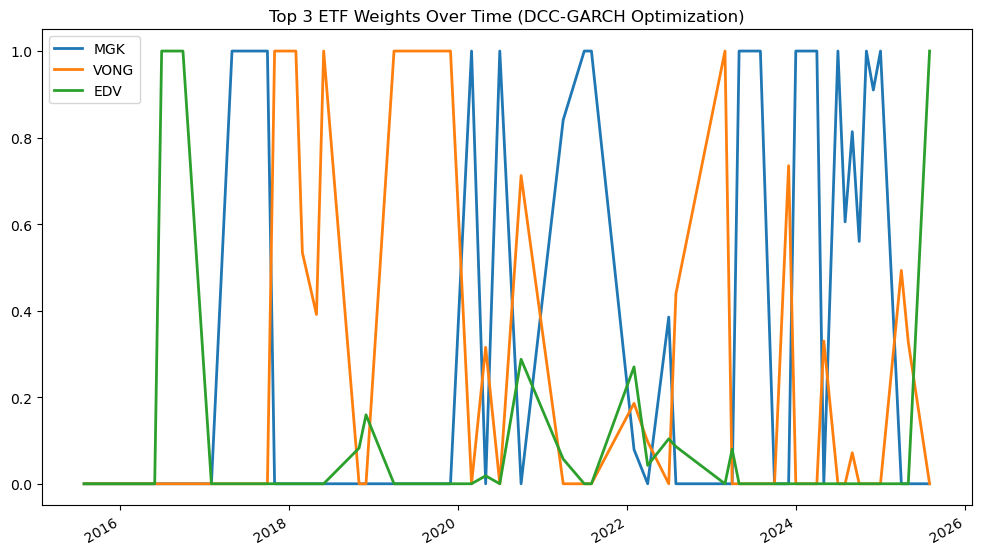

In [54]:
# ------------------------------------------------------------------------------
#  DCC-GARCH 
# ------------------------------------------------------------------------------
# Dynamic Conditional Correlation (DCC) GARCH models capture time-varying
# volatility and correlation, which is useful as correlations often spike
# during market crises.
#
# NOTE: The following is a custom implementation of a DCC(1,1) model.
# I do not know if this implementation is perfectly correct from a financial
# econometrics standpoint. Its correctness should be verified for production use.
# ------------------------------------------------------------------------------
def _dcc_negloglik(params, std_resids):
    """Negative log-likelihood of a DCC(1,1) model given standardized residuals."""
    T, N = std_resids.shape
    alpha, beta = params
    Qbar = np.cov(std_resids.T)  # Unconditional correlation
    Qt = Qbar.copy()  # Initialize Qt_0
    loglik = 0.0
    for t in range(T):
        eps_t = std_resids[t][:, None]  # (N,1)
        Qt = (1 - alpha - beta) * Qbar + alpha * (eps_t @ eps_t.T) + beta * Qt
        diag_sqrt = np.sqrt(np.diag(Qt))
        diag_sqrt[diag_sqrt <= 1e-12] = 1e-12
        Rt = Qt / np.outer(diag_sqrt, diag_sqrt)
        inv_Rt = np.linalg.inv(Rt)
        logdet_Rt = np.log(np.linalg.det(Rt))
        loglik += logdet_Rt + eps_t.T @ inv_Rt @ eps_t
    return 0.5 * loglik.item()


def fit_dcc(std_resids, bounds=((1e-6, 1 - 1e-6),) * 2):
    """Estimates (alpha, beta) by QML; returns params and last Qt, Rt."""
    best_val, best_ab = np.inf, None
    grid = np.linspace(0.01, 0.15, 5)
    for a in grid:
        for b in grid:
            if a + b < 0.999:
                val = _dcc_negloglik((a, b), std_resids)
                if val < best_val:
                    best_val, best_ab = val, (a, b)
    res = minimize(
        _dcc_negloglik,
        x0=np.array(best_ab),
        args=(std_resids,),
        bounds=bounds,
        constraints={"type": "ineq", "fun": lambda x: 0.999 - (x[0] + x[1])},
    )
    alpha, beta = max(res.x[0], 0), max(res.x[1], 0)
    if alpha + beta >= 0.999:
        beta = 0.999 - alpha - 1e-6

    Qbar = np.cov(std_resids.T)
    Qt = Qbar.copy()
    for eps in std_resids:
        eps = eps[:, None]
        Qt = (1 - alpha - beta) * Qbar + alpha * (eps @ eps.T) + beta * Qt
    Rt = Qt / np.outer(np.sqrt(np.diag(Qt)), np.sqrt(np.diag(Qt)))
    return alpha, beta, Qt, Rt


def forecast_dcc_cov(std_resids, cond_vars, horizon=1):
    """Produces a (horizon-step) ahead annualized covariance forecast."""
    alpha, beta, Qt_last, _ = fit_dcc(std_resids)
    Qbar = np.cov(std_resids.T)
    Qt_h = Qt_last.copy()
    for _ in range(horizon):
        Qt_h = (1 - alpha - beta) * Qbar + beta * Qt_h
    Rt_h = Qt_h / np.outer(np.sqrt(np.diag(Qt_h)), np.sqrt(np.diag(Qt_h)))
    var_h = cond_vars[-1]
    cov_h = np.outer(np.sqrt(var_h), np.sqrt(var_h)) * Rt_h
    return cov_h


print("\n--- Rolling DCC-GARCH Optimization ---")
try:
    # Step 1: Prepare weekly data for better GARCH model estimation
    surviving_etf_symbols = returns_monthly.columns.tolist()
    all_prices_daily = pd.concat(
        [get_total_return_series(t) for t in surviving_etf_symbols], axis=1
    ).tz_localize(None)
    returns_weekly = (
        all_prices_daily[surviving_etf_symbols]
        .resample("W-FRI")
        .last()
        .pct_change()
        .loc[returns_monthly.index.min() :]
        .dropna(how="all")
    )

    print("\n--- Testing for GARCH(1,1) Effects in Weekly Returns ---")
    for symbol in surviving_etf_symbols:
        series = returns_weekly[symbol].dropna()
        if len(series) < 20: continue
        lm_test = het_arch(series, nlags=12)
        print(f"{symbol}: ARCH LM Test p-value = {lm_test[1]:.4f}", end="")
        print("  -> ARCH effects detected" if lm_test[1] < 0.05 else "  -> No significant ARCH effects")

    # Step 2: Perform rolling DCC optimization
    month_ends = returns_weekly.resample("ME").last().index
    voo_sigma_annual_weekly = returns_weekly["VOO"].std() * np.sqrt(52)
    rolling_dcc_weights_list = []

    for date in month_ends:
        data_window = returns_weekly.loc[:date]
        if len(data_window) < 104: continue  # Need enough data

        try:
            print(f"Optimizing DCC portfolio for month-end {date.date()}...")
            std_resids, cond_vars = [], []
            scale = 100.0  # Rescale returns for better model fitting
            for s in etf_symbols:
                series = scale * data_window[s].dropna()
                am = ConstantMean(series)
                am.volatility = GARCH(1, 1)
                res = am.fit(disp="off")
                std_resids.append(res.std_resid)
                cond_vars.append((res.conditional_volatility / scale) ** 2)

            std_resids = np.column_stack(std_resids)
            cond_vars = np.column_stack(cond_vars)

            forecasted_cov = forecast_dcc_cov(std_resids, cond_vars) * 52
            forecasted_mu = data_window.mean().values * 52

            ef_dcc = efficient_frontier(forecasted_cov, forecasted_mu, n_points=30)
            _, w_dcc = select_portfolio(ef_dcc, "sigma", voo_sigma_annual_weekly)
            if w_dcc is not None:
                rolling_dcc_weights_list.append(pd.Series(w_dcc, index=etf_symbols, name=date))
        except Exception as e:
            print(f"  Skipped {date.date()} due to error: {e}")

    # Step 3: Process results
    if rolling_dcc_weights_list:
        dcc_weights_df = pd.concat(rolling_dcc_weights_list, axis=1).T
        top_dcc_etfs = dcc_weights_df.mean().sort_values(ascending=False).head(3).index
        dcc_weights_df[top_dcc_etfs].plot(
            figsize=(12, 7),
            title="Top 3 ETF Weights Over Time (DCC-GARCH Optimization)",
            lw=2,
        )
        plt.show()

        # Create monthly return series for the DCC strategy
        dcc_shifted_weights = dcc_weights_df.shift(1).reindex(returns_monthly.index).ffill()
        common_idx = dcc_shifted_weights.dropna().index.intersection(returns_monthly.index)
        aligned_weights = dcc_shifted_weights.loc[common_idx]
        aligned_returns = returns_monthly.loc[common_idx]
        dynamic_returns_series_dcc = pd.Series(
            np.sum(aligned_weights.values * aligned_returns[etf_symbols].values, axis=1),
            index=common_idx,
        )
    else:
        dynamic_returns_series_dcc = pd.Series(dtype=float)
        print("No successful DCC-GARCH optimizations were completed.")

except Exception as e:
    print(f"Failed to run DCC-GARCH analysis. Error: {e}")
    dynamic_returns_series_dcc = pd.Series(dtype=float)

Weight move quite a lot over time, but interestingly, they seem to be moving mostly across the Russell 1000 Growth ETFs, Mega Cap Growth ETF, and a treasury ETF, the Extended Duration Treasury ETF.  This makes sense to switch weights towards higher expected return portfolio if the expected market covariance/variance is low, and switch to lower volatility ETFs when expected volatility is high.  What is concerning, though, is that there are many instance with full weight on just one ETF, quite extreme weights that can quickly change.

### 5. Regime‑Switching Model

Estimate a two‑state Markov model (Hamilton, 1989) using macro/market factors (e.g., VIX).

In [ ]:
# ==============================================================================
print("\n--- Section 5: Building a Market Regime-Switching Model ---")
# --- 5a. Load Exogenous Economic Data ---
# We use VIX and the Treasury yield spread as indicators of the economic environment.
def get_fred_data(start, end):
    """Fetches US Treasury yield and VIX data from FRED."""
    print("Fetching VIX and yield curve data from FRED...")
    symbols = {"3M": "DGS3MO", "10Y": "DGS10", "VIX": "VIXCLS"}
    try:
        df = DataReader(list(symbols.values()), "fred", start, end)
        df = df.rename(columns={v: k for k, v in symbols.items()})
        df[["3M", "10Y"]] = df[["3M", "10Y"]] / 100.0  # Convert to decimal
        df["Spread_10Y_3M"] = df["10Y"] - df["3M"]
        return df.dropna()
    except Exception as e:
        print(f"Could not fetch FRED data: {e}")
        return pd.DataFrame()


exog_df = get_fred_data(returns_monthly.index.min(), returns_monthly.index.max())

# --- 5b. Align and Prepare Data for Modeling ---
# Align all data to our monthly return frequency
exog_monthly = exog_df.resample("ME").last().ffill()
common_index = returns_monthly.index.intersection(exog_monthly.index)
returns_aligned = returns_monthly.loc[common_index]
exog_aligned = exog_monthly.loc[common_index]

# Use LAGGED economic data to predict the NEXT month's regime to prevent lookahead bias
exog_lagged = exog_aligned.shift(1).dropna()
final_index = returns_aligned.index.intersection(exog_lagged.index)
returns_final = returns_aligned.loc[final_index]
exog_final_lagged = exog_lagged.loc[final_index, ["VIX", "Spread_10Y_3M"]]
endog_voo = returns_final["VOO"]  # Market returns (VOO) drive regime identification

print(f"Final dataset for regime modeling has {len(endog_voo)} monthly observations.")

# --- 5c. Fit the Markov Regime-Switching Model ---
# We test models with different numbers of regimes and select the best one based on BIC.
models = {}
for k in range(2, MAX_REGIMES_TO_TEST + 1):
    print(f"Fitting model with {k} regimes...")
    try:
        mod = MarkovRegression(
            endog=endog_voo,
            k_regimes=k,
            trend="c",  # Constant mean term in each regime
            switching_variance=True,
            exog_tvtp=sm.add_constant(exog_final_lagged),  # Time-Varying Transition Probs
        )
        res = mod.fit(search_reps=20)
        # Validate that each regime has a sufficient number of observations
        assigned_regimes = res.smoothed_marginal_probabilities.idxmax(axis=1)
        if (assigned_regimes.value_counts() < MIN_OBS_PER_REGIME).any():
            print(f"  > Model with {k} regimes rejected: a regime had insufficient data.")
            continue
        models[k] = res
        print(f"  > Model with {k} regimes is valid. BIC: {res.bic:.2f}")
    except Exception as e:
        print(f"  > Failed to fit model with {k} regimes: {e}")

if not models:
    raise RuntimeError("No suitable regime-switching models could be fitted.")

# Select the model with the lowest BIC
best_k = min(models, key=lambda k: models[k].bic)
best_model_results = models[best_k]
print(f"\nBest model selected: {best_k} regimes (Lowest BIC = {best_model_results.bic:.2f})")

# --- 5d. Interpret and Label the Regimes ---
# To make regimes interpretable, we sort them by their volatility.
regime_vols = best_model_results.params.filter(like="sigma2").sort_values()
regime_order = regime_vols.index.str.extract(r"\[(\d+)\]")[0].astype(int)
regime_map = {old_idx: new_idx for new_idx, old_idx in enumerate(regime_order)}

# Display characteristics of each sorted regime
sorted_params = pd.DataFrame()
for i in range(best_k):
    original_idx = regime_order.iloc[i]
    # Annualize parameters for interpretability
    mean_ann = best_model_results.params[f"const[{original_idx}]"] * 12 * 100
    vol_ann = np.sqrt(best_model_results.params[f"sigma2[{original_idx}]"]) * np.sqrt(12) * 100
    sorted_params[f"Regime {i}"] = [f"{mean_ann:.1f}%", f"{vol_ann:.1f}%"]
sorted_params.index = ["Annualized Mean (VOO)", "Annualized Volatility (VOO)"]
print("\nCharacteristics of Identified Market Regimes (Sorted by Volatility):")
print(sorted_params)

# Get the final, sorted series of regime probabilities
smoothed_probs = best_model_results.smoothed_marginal_probabilities.rename(
    columns=regime_map
).sort_index(axis=1)
regime_series = smoothed_probs.idxmax(axis=1).rename("regime")


# ==============================================================================

### 6. Regime‑Aware Dynamic Strategy

Combine regime probabilities with pre‑computed optimal portfolios to adapt allocations.

In [ ]:
# ==============================================================================
print("\n--- Section 6: Building and Backtesting the Dynamic Strategy ---")
# --- 6a. Calculate Regime-Specific Optimal Portfolios ---
# We compute a separate optimal portfolio for each identified regime.
regime_frontiers = {}
regime_optimal_weights = {}
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, best_k))

for i in range(best_k):
    print(f"\nAnalyzing Regime {i}...")
    in_regime_periods = regime_series == i
    if in_regime_periods.sum() < max(24, n_assets):
        print(f"  > Skipping Regime {i}, not enough data. Using VOO as fallback.")
        w_fallback = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
        regime_optimal_weights[i] = w_fallback
        continue

    # Estimate parameters using only data from this regime
    returns_regime = returns_final[in_regime_periods]
    mu_regime = (returns_regime.mean().values * 12) - expense_vector
    cov_regime = LedoitWolf().fit(returns_regime.values).covariance_ * 12

    # Generate the efficient frontier for this regime
    ef_regime = prune_frontier(efficient_frontier(cov_regime, mu_regime, n_points=FRONTIER_POINTS))
    regime_frontiers[i] = ef_regime

    # Find optimal portfolio by matching the overall VOO benchmark's volatility
    _, w_opt = select_portfolio(ef_regime, "sigma", voo_sigma_annual)
    if w_opt is not None:
        regime_optimal_weights[i] = w_opt
        print(f"  > Top 3 ETFs for Regime {i} Portfolio (matching VOO vol):")
        top_indices = np.argsort(w_opt)[-3:][::-1]
        for idx in top_indices:
            if w_opt[idx] > 0.01:
                symbol = etf_symbols[idx]
                name = etf_name_map.get(symbol, "Unknown")
                print(f"    {symbol} ({name}): {w_opt[idx]:.2%}")

        # Plot the frontier and the selected optimal point
        plt.plot(
            ef_regime["sigma"], ef_regime["mu"], label=f"Regime {i} Frontier", color=colors[i], lw=2
        )
        opt_sigma = np.sqrt(w_opt.T @ cov_regime @ w_opt)
        opt_mu = w_opt.T @ mu_regime
        plt.scatter(
            opt_sigma, opt_mu, marker="*", s=250, color=colors[i], zorder=5, edgecolors="black"
        )
    else:
        print("  > Could not find optimal portfolio. Using VOO as fallback.")
        w_fallback = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
        regime_optimal_weights[i] = w_fallback

# Finalize and show the plot of all regime frontiers
plt.scatter([voo_sigma_annual], [voo_mu_annual], color="black", marker="X", s=200, label="VOO (Overall)", zorder=5)
plt.title("Efficient Frontiers for Each Market Regime", fontsize=16)
plt.xlabel("Annualized Volatility (sigma)", fontsize=12)
plt.ylabel("Annualized Return (mu)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6b. Backtest the Dynamic Strategy ---
# At each month, the portfolio is a blend of the regime-optimal portfolios,
# weighted by the smoothed probability of being in each regime at that time.
dynamic_weights_list = []
for t in range(len(returns_final)):
    probs_t = smoothed_probs.iloc[t]
    blended_w = np.zeros(n_assets)
    # Create blended portfolio by weighting each regime's portfolio by its probability
    for i in range(best_k):
        if i in regime_optimal_weights:
            blended_w += probs_t[i] * regime_optimal_weights[i]
    dynamic_weights_list.append(blended_w / blended_w.sum())

# Calculate the monthly returns of this dynamic portfolio
dynamic_port_returns = np.sum(
    np.array(dynamic_weights_list) * returns_final[etf_symbols].values, axis=1
)
dynamic_returns_series = pd.Series(dynamic_port_returns, index=returns_final.index)


# ==============================================================================

### 7. Final Performance Comparison

Plot cumulative growth, display key performance metrics, and run Monte‑Carlo forecasts.

In [ ]:
# ==============================================================================
print("\n--- Section 7: Comparing All Strategies ---")


# --- 7a. Define a Performance Metrics Calculator ---
def calculate_performance_metrics(returns_series):
    """
    Calculates key performance metrics for a series of returns.

    Args:
        returns_series (pd.Series): A series of periodic (e.g., monthly) returns.

    Returns:
        dict: A dictionary of performance metrics.
    """
    if returns_series.empty or returns_series.isnull().all():
        return {
            "Total Return (%)": np.nan, "Annualized Return (%)": np.nan,
            "Annualized Volatility (%)": np.nan, "Sharpe Ratio": np.nan,
            "Max Drawdown (%)": np.nan,
        }
    n_periods_per_year = 12  # For monthly returns
    ann_return = ((1 + returns_series.mean()) ** n_periods_per_year - 1) * 100
    ann_vol = returns_series.std() * np.sqrt(n_periods_per_year) * 100
    sharpe = sharpe_ratio(ann_return / 100, ann_vol / 100)
    
    cumulative_returns = (1 + returns_series).cumprod()
    total_return = (cumulative_returns.iloc[-1] - 1) * 100
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak - 1) * 100
    max_drawdown = drawdown.min()

    return {
        "Total Return (%)": total_return,
        "Annualized Return (%)": ann_return,
        "Annualized Volatility (%)": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown (%)": max_drawdown,
    }


# --- 7b. Prepare All Strategy Returns for Comparison ---
# Use a common lookback window for a fair comparison
lookback_years = 7
end_date_lookback = max(returns_final.index)
start_date_lookback = end_date_lookback - pd.DateOffset(years=lookback_years)
returns_win = returns_final.loc[start_date_lookback:end_date_lookback].dropna(how="all")

# Helper function to calculate strategy returns safely
def get_strategy_returns(weights):
    if weights is not None:
        return returns_win[etf_symbols] @ weights
    return pd.Series(dtype=float, index=returns_win.index)

strategies = {
    "VOO Benchmark": returns_win["VOO"],
    "Static Raw (Risk-Match)": get_strategy_returns(w_sigma_raw),
    "Static L1 Regularized (Risk-Match)": get_strategy_returns(w_sigma_reg_l1),
    "Static Shrunk (Risk-Match)": get_strategy_returns(w_sigma_shrunk),
    "Static Resampled": get_strategy_returns(w_resampled),
    "Black-Litterman": get_strategy_returns(w_bl_opt),
    "Risk Parity": get_strategy_returns(rp_weights),
    "Hierarchical Risk Parity": get_strategy_returns(hrp_weights),
    "HRP-MVO Blended": get_strategy_returns(w_tilt),
    "DCC-GARCH Dynamic": dynamic_returns_series_dcc.loc[start_date_lookback:end_date_lookback],
    "Regime-Aware Dynamic": dynamic_returns_series.loc[start_date_lookback:end_date_lookback],
}


# --- 7c. Plot Cumulative Performance ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
for name, rtn in strategies.items():
    if rtn.dropna().empty: continue
    growth = (1 + rtn).cumprod()
    if name.lower().startswith("voo"):
        growth.plot(ax=ax, label=name, lw=3, linestyle="--", color="black")
    else:
        growth.plot(ax=ax, label=name, lw=2)
ax.set_title(f"Cumulative Performance – Last {lookback_years} Years", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Growth of $1 (log scale)", fontsize=12)
ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# --- 7d. Display Final Performance Metrics Table ---
all_perf_metrics = {name: calculate_performance_metrics(ret.dropna()) for name, ret in strategies.items()}
all_perf_df = pd.DataFrame(all_perf_metrics).T
print("\n" + "=" * 70)
print("      COMPREHENSIVE STRATEGY PERFORMANCE METRICS")
print("=" * 70)
print(all_perf_df.sort_values(by="Sharpe Ratio", ascending=False))
print("=" * 70 + "\n")


# --- 7e. Visualize Regime Probabilities vs. Market Returns ---
fig, axes = plt.subplots(
    2, 1, figsize=(14, 8), sharex=True, gridspec_kw={"height_ratios": [3, 2]}
)
smoothed_probs.plot(ax=axes[0], kind="area", stacked=True, colormap="viridis", alpha=0.8)
axes[0].set_title("Smoothed Probabilities of Each Market Regime Over Time", fontsize=14)
axes[0].set_ylabel("Probability")
axes[0].legend(title="Regime", loc="upper left")
returns_final["VOO"].plot(ax=axes[1], color="black", label="VOO Monthly Return", alpha=0.7)
axes[1].set_title("VOO Monthly Returns", fontsize=14)
axes[1].set_ylabel("Return")
axes[1].axhline(0, color="grey", lw=1, linestyle="--")
plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()


# --- 7f. Monte Carlo Simulation ---
# Simulate future returns to see how our portfolios might perform under a wide
# range of possible outcomes, based on the historical return distribution.
print(f"Running Monte Carlo simulation with {MC_SIM_SCENARIOS} scenarios...")
# Use monthly parameters from the full sample for the simulation
monthly_mu_sample = annual_mu / 12
rng = np.random.default_rng(seed=42)  # For reproducibility

# Generate all simulated paths at once for efficiency
simulated_returns_monthly = rng.multivariate_normal(
    mean=monthly_mu_sample,
    cov=sample_cov,  # Use the original sample covariance
    size=(MC_SIM_SCENARIOS, MC_SIM_HORIZON_MONTHS),
)


def simulate_portfolio_performance(weights):
    """Calculates performance metrics from simulated return paths."""
    if weights is None or np.isnan(weights).any():
        return {
            "Mean Ann. Return (%)": np.nan, "Ann. Volatility (%)": np.nan,
            "Sharpe Ratio": np.nan, "VaR 5% (Ann.) (%)": np.nan,
        }
    portfolio_sim_returns = simulated_returns_monthly @ weights
    # Calculate annualized metrics from the simulation results
    mean_monthly_return = np.mean(portfolio_sim_returns)
    std_monthly_return = np.std(portfolio_sim_returns)
    
    annual_mean_return = mean_monthly_return * 12 * 100
    annual_volatility = std_monthly_return * np.sqrt(12) * 100
    sharpe = sharpe_ratio(annual_mean_return/100, annual_volatility/100)
    
    # Value-at-Risk (VaR): The worst expected annualized loss at a 5% confidence level.
    var_5_percent = np.percentile(portfolio_sim_returns, 5) * 12 * 100
    
    return {
        "Mean Ann. Return (%)": annual_mean_return,
        "Ann. Volatility (%)": annual_volatility,
        "Sharpe Ratio": sharpe,
        "VaR 5% (Ann.) (%)": var_5_percent,
    }

# Define weights for all strategies to be simulated
voo_weights = np.array([1.0 if s == "VOO" else 0.0 for s in etf_symbols])
simulation_portfolios = {
    "VOO Benchmark": voo_weights,
    "Static Raw (Risk-Match)": w_sigma_raw,
    "Static L1 Regularized (Risk-Match)": w_sigma_reg_l1,
    "Static Shrunk (Risk-Match)": w_sigma_shrunk,
    "Static Resampled": w_resampled,
    "Black-Litterman": w_bl_opt,
    "Risk Parity": rp_weights,
    "Hierarchical Risk Parity": hrp_weights,
    "HRP-MVO Blended": w_tilt,
}

# Run simulation for each portfolio
sim_results = {name: simulate_portfolio_performance(w) for name, w in simulation_portfolios.items()}
sim_results_df = pd.DataFrame(sim_results).T

print("\n" + "=" * 70)
print(f"      MONTE CARLO SIMULATION SUMMARY ({MC_SIM_HORIZON_MONTHS // 12}-YEAR HORIZON)")
print("=" * 70)
print(sim_results_df.sort_values(by="Sharpe Ratio", ascending=False))
print("=" * 70 + "\n")

print("--- Analysis Complete ---")

### Section 8. Back-Testing Framework: 10-Year Fit, 3-Year Out-of-Sample

This section evaluates how well our **Mean-Variance (MV) optimizer** and the **Markov Regime-Switching (MRS) model** perform on **unseen data**.  
We:

1. **Fit** parameters on the *preceding* 10 years (120 monthly observations).  
2. **Rebalance** monthly over the *next* 3 years (36 months) using:
   - **Raw MV**: classic Markowitz weights based on sample mean & covariance.  
   - **MRS-MV**: MV weights *conditional* on the regime inferred by a 2-state Gaussian MRS model.  
3. **Benchmark** against **VOO**.  
4. **Report** cumulative growth, risk metrics, and weight dynamics.

> **Timeline**  
> • *Fit window*: **T-10y to T-3y**  
> • *Test window*: **T-3y to T**  
> (Here **T** = latest date in `returns_monthly`.)

In [ ]:
def split_windows(returns, fit_years=10, test_years=3):
    """Return training and testing DataFrames given total monthly returns."""
    end_test   = returns.index.max()
    start_test = end_test - relativedelta(years=test_years) + relativedelta(months=1)
    start_fit  = start_test - relativedelta(years=fit_years)
    train = returns.loc[start_fit : start_test - relativedelta(months=1)]
    test  = returns.loc[start_test : end_test]
    return train, test

def mv_weights(mu, cov, long_only=True):
    """Closed-form MV weights for minimum-variance at target return = mean of mu."""
    import cvxopt as opt
    n = len(mu)
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros(n))
    A = opt.matrix(np.vstack([np.ones(n), mu]))
    b = opt.matrix([1.0, mu.mean()])
    G = opt.matrix(-np.eye(n)) if long_only else None
    h = opt.matrix(np.zeros(n)) if long_only else None
    sol = opt.solvers.qp(P, q, G, h, A, b)
    return np.array(sol['x']).flatten()


### References

* Markowitz, H. (1952). **Portfolio Selection**. *Journal of Finance*, 7(1), 77–91.  
* Ledoit, O., & Wolf, M. (2004). **Honey, I Shrunk the Sample Covariance Matrix**. *Journal of Portfolio Management*, 30(4).  
* Black, F., & Litterman, R. (1992). **Global Portfolio Optimization**. *Financial Analysts Journal*, 48(5).  
* Michaud, R. (1998). **Efficient Asset Management**. Harvard Business School Press.  
* Engle, R. (2002). **Dynamic Conditional Correlation—A Simple Class of Multivariate GARCH Models**. *Journal of Business & Economic Statistics*, 20(3).  
* Maillard, S., Roncalli, T., & Teïletche, J. (2010). **The Properties of Equally Weighted Risk Contribution Portfolios**. *Journal of Portfolio Management*, 36(4).  
* López de Prado, M. (2020). **Advances in Financial Machine Learning**. Wiley.